In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Настройка стилей визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

In [2]:
!unzip dataset.zip

Archive:  dataset.zip
  inflating: словарь_соцдема.csv  
  inflating: датасет_new.csv  


In [3]:
# Загрузка данных
print("ЗАГРУЗКА И БАЗОВЫЙ АНАЛИЗ")

df1 = pd.read_csv('датасет_new.csv')
df2 = pd.read_csv('словарь_соцдема.csv')

# Переименование столбцов согласно требованиям
df1.columns = ['event_dt', 'screen', 'feature', 'action',
              'device_id', 'session_id', 'device_vendor',
              'device_model', 'device_type', 'os']

df2.columns = ['device_id', 'age', 'gender']

print(f"\nРазмер основного датасета: {df1.shape}")
print(f"Количество строк: {df1.shape[0]:,}")
print(f"Количество столбцов: {df1.shape[1]}")
print(f"\nРазмер словаря: {df2.shape}")
print(f"Уникальных пользователей: {df2['device_id'].nunique():,}")

ЗАГРУЗКА И БАЗОВЫЙ АНАЛИЗ

Размер основного датасета: (6269242, 10)
Количество строк: 6,269,242
Количество столбцов: 10

Размер словаря: (180341, 3)
Уникальных пользователей: 180,341


In [4]:
# Базовый анализ
print("\nИНФОРМАЦИЯ О ДАТАСЕТЕ:")
print(df1.info())

print("\nСТАТИСТИКА ПО ЧИСЛОВЫМ СТОЛБЦАМ:")
print(df1.describe().T)

print("\nСТАТИСТИКА ПО КАТЕГОРИАЛЬНЫМ СТОЛБЦАМ:")
categorical_cols = ['screen', 'feature', 'action', 'device_vendor',
                    'device_model', 'device_type', 'os']
for col in categorical_cols:
    if col in df1.columns:
        print(f"\n{col}:")
        print(f"  Уникальных значений: {df1[col].nunique()}")
        print(f"  Топ-5 самых частых:")
        for val, count in df1[col].value_counts().head().items():
            print(f"    {val}: {count:,} ({count/len(df1)*100:.1f}%)")

import time

print("\nПервые 5 строк основного датасета:")
print(df1.head())

print("\nПервые 5 строк словаря:")
print(df2.head())



ИНФОРМАЦИЯ О ДАТАСЕТЕ:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6269242 entries, 0 to 6269241
Data columns (total 10 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   event_dt       object
 1   screen         object
 2   feature        object
 3   action         object
 4   device_id      int64 
 5   session_id     int64 
 6   device_vendor  object
 7   device_model   object
 8   device_type    object
 9   os             object
dtypes: int64(2), object(8)
memory usage: 478.3+ MB
None

СТАТИСТИКА ПО ЧИСЛОВЫМ СТОЛБЦАМ:
                count          mean           std           min           25%  \
device_id   6269242.0  5.940995e+04  45758.020465  1.000000e+00  2.255000e+04   
session_id  6269242.0  1.000000e+10    847.857164  1.000000e+10  1.000000e+10   

                     50%           75%           max  
device_id   4.795450e+04  8.854300e+04  1.803410e+05  
session_id  1.000000e+10  1.000000e+10  1.000002e+10  

СТАТИСТИКА ПО КАТЕГОРИАЛЬНЫМ СТОЛБЦАМ:

In [5]:
# Преобразование timestamp
print("\nПреобразование event_dt...")
start_time = time.time()

# Убираем временную зону в квадратных скобках
df1['timestamp_clean'] = df1['event_dt'].str.split('[').str[0]

# Используем pd.to_datetime с обработкой разных форматов
df1['event_dt'] = pd.to_datetime(df1['timestamp_clean'], format='mixed', utc=True)

# Убираем временную зону для удобства (опционально)
df1['event_dt'] = df1['event_dt'].dt.tz_convert(None)

# Удаляем временную колонку
df1 = df1.drop('timestamp_clean', axis=1)

print(f"Преобразование заняло: {time.time() - start_time:.2f} секунд")

# Создание node_id
print("\nСоздание node_id...")
df1['node_id'] = df1['screen'] + '_' + df1['feature']
print(f"Создано уникальных node_id: {df1['node_id'].nunique()}")

# Анализ временного периода
max_time, min_time = df1['event_dt'].max(), df1['event_dt'].min()
print(f"\nДанные за период с {min_time} по {max_time}")
print(f"Общая продолжительность: {max_time - min_time}")


Преобразование event_dt...
Преобразование заняло: 45.81 секунд

Создание node_id...
Создано уникальных node_id: 170

Данные за период с 2025-08-31 21:00:05 по 2025-10-31 20:59:54
Общая продолжительность: 60 days 23:59:49


In [6]:
# Анализ дубликатов
print(f"\nИз {df1.shape[0]} строк в основном датасете, дубликатов {df1.duplicated().sum()}")
print(f"Из {df2.shape[0]} строк в словаре, дубликатов {df2.duplicated().sum()}")


Из 6269242 строк в основном датасете, дубликатов 2908592
Из 180341 строк в словаре, дубликатов 0


In [7]:
# Удаление дубликатов
print("\nУдаление дубликатов...")
df1 = df1.drop_duplicates()
print(f"{df1.shape[0]} строк осталось после удаления дубликатов.")


Удаление дубликатов...
3360650 строк осталось после удаления дубликатов.


In [8]:
# Анализ уникальных устройств
quantity1 = df1['device_id'].nunique()
quantity2 = df2['device_id'].nunique()
print(f'\nУникальных устройств в основном датасете: {quantity1}')
print(f'Уникальных устройств в словаре: {quantity2}')


Уникальных устройств в основном датасете: 179976
Уникальных устройств в словаре: 180341


In [9]:
# Объединение данных
print("\nОбъединение данных...")
mask_missing = ~df1["device_id"].isin(df2["device_id"])
missing_ids = df1.loc[mask_missing, "device_id"].unique()
num_lost = len(missing_ids)
print(f"Количество устройств, присутствующих в основном датасете, но отсутствующих в словаре: {num_lost}")

df = df1.merge(df2, on='device_id', how='left')
print(f"Размер объединенного датафрейма: {df.shape}")


Объединение данных...
Количество устройств, присутствующих в основном датасете, но отсутствующих в словаре: 0
Размер объединенного датафрейма: (3360650, 13)


In [10]:
# Анализ пропущенных значений
print("\nПропущенные значения в объединенном датафрейме:")
missing_values = df.isnull().sum()
missing_pct = (missing_values / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Количество': missing_values, 'Процент': missing_pct})
print(missing_df[missing_df['Количество'] > 0])

# Особый анализ пропусков в action
print("Детальный анализ пропусков в 'action':")
users_with_missing_action = df[df['action'].isnull()]['device_id'].nunique()
total_users = df['device_id'].nunique()
print(f"Пользователей с пропущенным action: {users_with_missing_action:,} из {total_users:,} ({users_with_missing_action/total_users*100:.1f}%)")




Пропущенные значения в объединенном датафрейме:
        Количество  Процент
action     1765376    52.53
age          17107     0.51
gender       21520     0.64
Детальный анализ пропусков в 'action':
Пользователей с пропущенным action: 169,395 из 179,976 (94.1%)


In [11]:
# Дата и время первого и последнего действия для каждого пользователя
user_activity = df.groupby('device_id')['event_dt'] \
                  .agg(['min', 'max']) \
                  .rename(columns={'min': 'first_event', 'max': 'last_event'})

# Определение пороговой даты для "ушедших" (30+ дней неактивности)
cutoff_date = df['event_dt'].max() - timedelta(days=30)
users_left = user_activity[user_activity['last_event'] <= cutoff_date]
users_left = users_left.reset_index()

print(f"\nКоличество пользователей, ушедших из приложения: {len(users_left):,}")
print(f"Общее количество уникальных пользователей: {len(user_activity):,}")
print(f"Процент оттока: {len(users_left)/len(user_activity)*100:.2f}%")


Количество пользователей, ушедших из приложения: 62,568
Общее количество уникальных пользователей: 179,976
Процент оттока: 34.76%


Количество is_finish = 1: 1,002,265
Процент событий с is_finish = 1: 29.82%

Действий у ушедших пользователей: 432,763
Действий у активных пользователей: 2,927,887


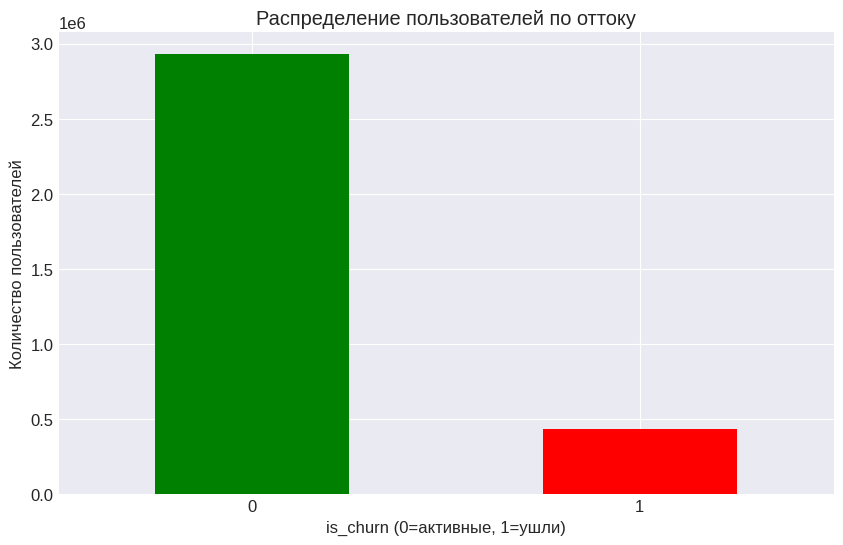


Столбцы в датафрейме: ['event_dt', 'screen', 'feature', 'action', 'device_id', 'session_id', 'device_vendor', 'device_model', 'device_type', 'os', 'node_id', 'age', 'gender', 'is_churn', 'is_finish']

Первые 3 строки датафрейма:
                              node_id            event_dt        screen  \
614672            Еще_Открытие экрана 2025-09-01 08:31:05           Еще   
614671  Еще_Переход в раздел 'Заявки' 2025-09-01 08:31:06           Еще   
614674   Новая заявка_Открытие экрана 2025-09-01 08:31:06  Новая заявка   

                          feature                  action  device_id  \
614672            Открытие экрана                     NaN          1   
614671  Переход в раздел 'Заявки'  Тап на кнопку 'Заявки'          1   
614674            Открытие экрана                     NaN          1   

        is_churn  is_finish  
614672         0          0  
614671         0          0  
614674         0          0  


In [12]:
# Добавляем столбец 'is_churn' (отток)
df['is_churn'] = df['device_id'].isin(users_left['device_id']).astype(int)

# Определение is_finish (последняя нода в сессии)

# Сортируем данные для определения последнего события в сессии
df = df.sort_values(['device_id', 'session_id', 'event_dt'])

# Определяем последнее событие в каждой сессии
df['is_finish'] = 0
last_in_session = df.drop_duplicates(['device_id', 'session_id'], keep='last').index
df.loc[last_in_session, 'is_finish'] = 1

print(f"Количество is_finish = 1: {df['is_finish'].sum():,}")
print(f"Процент событий с is_finish = 1: {df['is_finish'].mean()*100:.2f}%")

# Разделение на ушедших и активных
df_left = df[df['is_churn'] == 1]
df_active = df[df['is_churn'] == 0]

print(f"\nДействий у ушедших пользователей: {len(df_left):,}")
print(f"Действий у активных пользователей: {len(df_active):,}")

# Визуализация распределения оттока
plt.figure(figsize=(10, 6))
df['is_churn'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Распределение пользователей по оттоку')
plt.xlabel('is_churn (0=активные, 1=ушли)')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=0)
plt.show()

print(f"\nСтолбцы в датафрейме: {list(df.columns)}")
print("\nПервые 3 строки датафрейма:")
print(df[['node_id', 'event_dt', 'screen', 'feature', 'action',
          'device_id', 'is_churn', 'is_finish']].head(3))

АНАЛИЗ ОТТОКА ПО ДЕМОГРАФИЧЕСКИМ ПРИЗНАКАМ

Отток по возрастным группам (%):
             Ушли  Активны    Всего  Доля ушедших, %
age_group                                           
18–24       15450    72797    88247            17.51
25–30       35404   207390   242794            14.58
31-40      138123   885474  1023597            13.49
41–50      129930   874588  1004518            12.93
51–60       64744   507623   572367            11.31
61–70       33813   292541   326354            10.36
71–101      10445    75221    85666            12.19


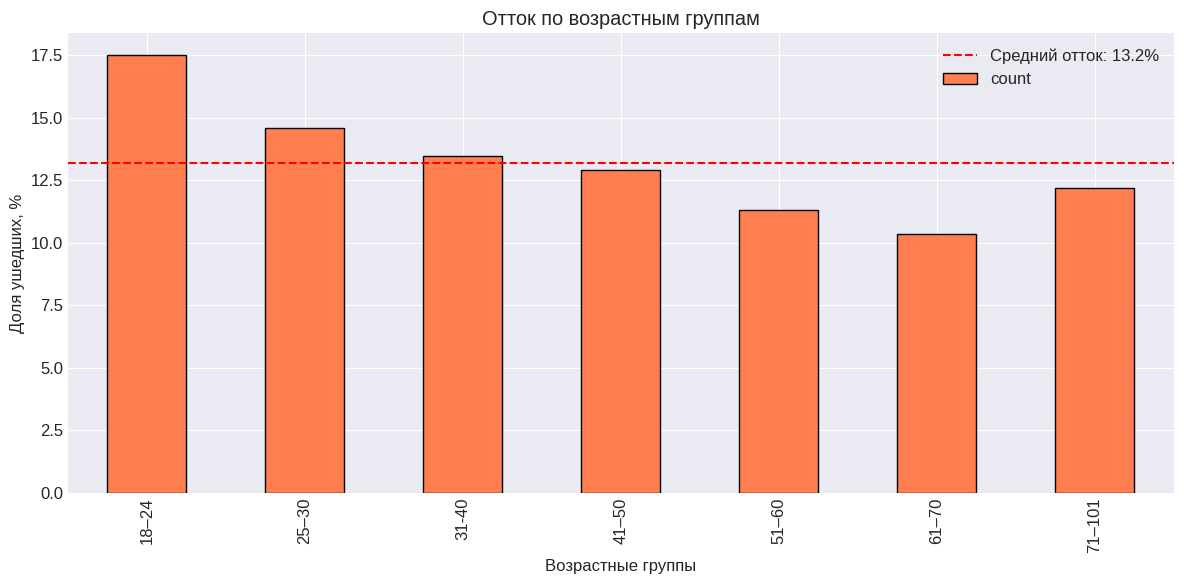


----------------------------------------
Отток по полу:
          Ушли  Активны    Всего  Доля ушедших, %
gender                                           
Ж       243399  1657945  1901344            12.80
М       183589  1254197  1437786            12.77

----------------------------------------
Отток по операционной системе:
           Ушли  Активны    Всего  Доля ушедших, %
os                                                
Android  222541  1716307  1938848            11.48
iOS      210222  1211580  1421802            14.79


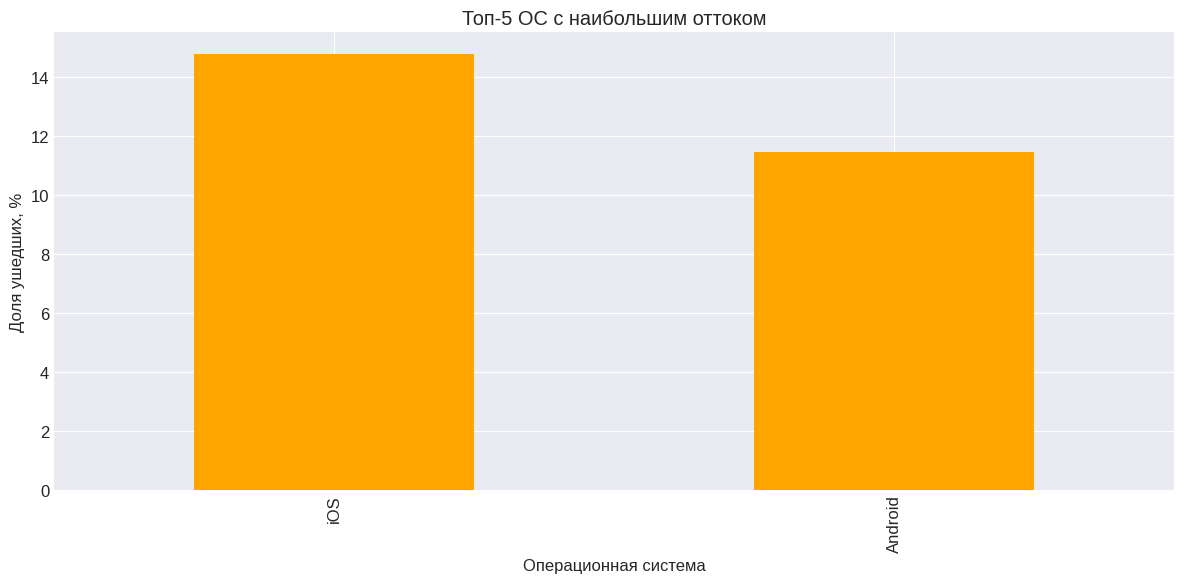

In [13]:

print("АНАЛИЗ ОТТОКА ПО ДЕМОГРАФИЧЕСКИМ ПРИЗНАКАМ")


# Создание возрастных групп
bins = [18, 25, 31, 41, 51, 61, 71, 101]
labels = ['18–24', '25–30', '31-40', '41–50', '51–60', '61–70', '71–101']

df_left = df[df['is_churn'] == 1]
df_active = df[df['is_churn'] == 0]

df_left['age_group'] = pd.cut(df_left['age'], bins=bins, labels=labels, right=True, include_lowest=True)
df_active['age_group'] = pd.cut(df_active['age'], bins=bins, labels=labels, right=True, include_lowest=True)

# Анализ оттока по возрастным группам
left_counts = df_left['age_group'].value_counts().sort_index()
active_counts = df_active['age_group'].value_counts().sort_index()
total_counts = left_counts + active_counts
share_left = left_counts / total_counts * 100

print("\nОтток по возрастным группам (%):")
age_churn_df = pd.DataFrame({
    'Ушли': left_counts,
    'Активны': active_counts,
    'Всего': total_counts,
    'Доля ушедших, %': share_left.round(2)
})
print(age_churn_df)

# Визуализация оттока по возрасту
plt.figure(figsize=(12, 6))
share_left.plot(kind='bar', color='coral', edgecolor='black')
plt.ylabel('Доля ушедших, %')
plt.xlabel('Возрастные группы')
plt.title('Отток по возрастным группам')
plt.axhline(y=share_left.mean(), color='red', linestyle='--',
            label=f'Средний отток: {share_left.mean():.1f}%')
plt.legend()
plt.tight_layout()
plt.show()

# Отток по полу
print("\n" + "-" * 40)
print("Отток по полу:")

left_counts_gender = df_left['gender'].value_counts().sort_index()
active_counts_gender = df_active['gender'].value_counts().sort_index()
total_counts_gender = left_counts_gender + active_counts_gender
share_left_gender = (left_counts_gender / total_counts_gender * 100).round(2)

gender_churn_df = pd.DataFrame({
    'Ушли': left_counts_gender,
    'Активны': active_counts_gender,
    'Всего': total_counts_gender,
    'Доля ушедших, %': share_left_gender
})
print(gender_churn_df)

# Отток по операционной системе
print("\n" + "-" * 40)
print("Отток по операционной системе:")

left_counts_os = df_left['os'].value_counts()
active_counts_os = df_active['os'].value_counts()
total_counts_os = left_counts_os + active_counts_os
share_left_os = (left_counts_os / total_counts_os * 100).round(2)

os_churn_df = pd.DataFrame({
    'Ушли': left_counts_os,
    'Активны': active_counts_os,
    'Всего': total_counts_os,
    'Доля ушедших, %': share_left_os
})
print(os_churn_df.head(10))  # Показываем топ-10

# Визуализация оттока по ОС (топ-5)
plt.figure(figsize=(12, 6))
os_churn_df_sorted = os_churn_df.sort_values('Доля ушедших, %', ascending=False).head(5)
os_churn_df_sorted['Доля ушедших, %'].plot(kind='bar', color='orange')
plt.title('Топ-5 ОС с наибольшим оттоком')
plt.ylabel('Доля ушедших, %')
plt.xlabel('Операционная система')
plt.tight_layout()
plt.show()

АНАЛИЗ ТЕХНИЧЕСКИХ ФАКТОРОВ ОТТОКА
Отток по типу устройства:
               Ушли  Активны    Всего  Доля ушедших, %
device_type                                           
phone        427651  2900036  3327687            12.85
tablet         5112    27851    32963            15.51
Отток по производителю устройств (топ-10):
                   Ушли    Активны      Всего  Доля ушедших, %
device_vendor                                                 
Apple          210222.0  1211580.0  1421802.0            14.79
Samsung         71891.0   549468.0   621359.0            11.57
Redmi           31306.0   283365.0   314671.0             9.95
Huawei          23505.0   174860.0   198365.0            11.85
Xiaomi          23766.0   165747.0   189513.0            12.54
POCO            14703.0   121057.0   135760.0            10.83
Realme          12820.0   102904.0   115724.0            11.08
Honor           10506.0    76025.0    86531.0            12.14
Tecno            6193.0    53318.0    59511.0 

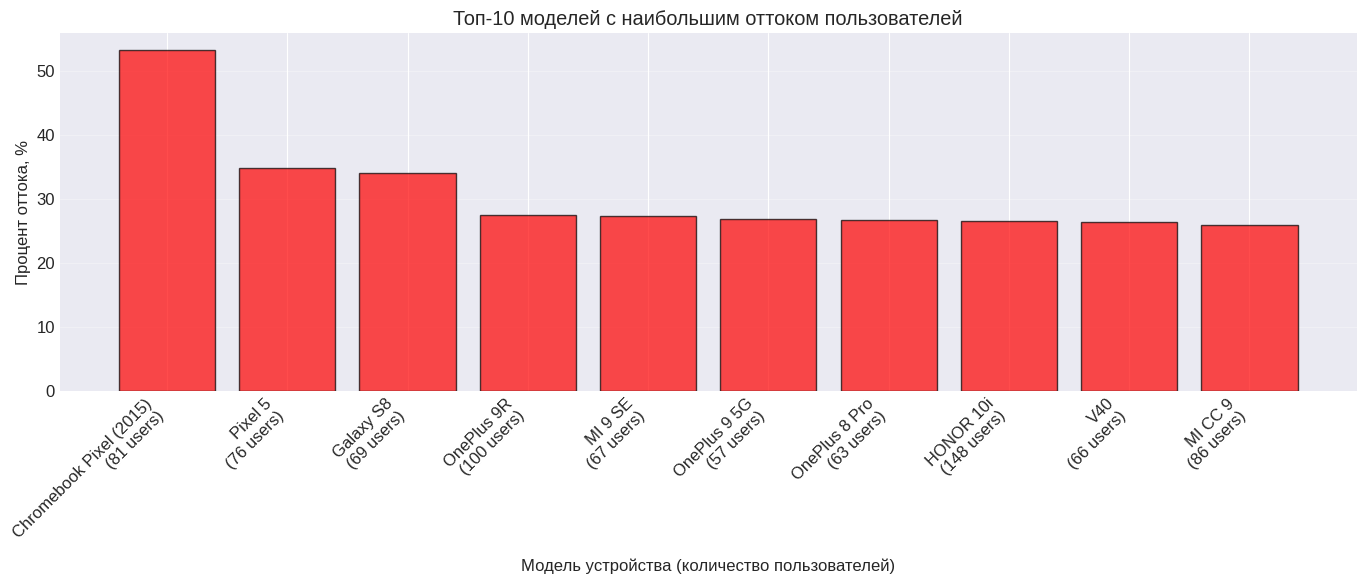

In [14]:
print("АНАЛИЗ ТЕХНИЧЕСКИХ ФАКТОРОВ ОТТОКА")


# Отток по типу устройства
print("Отток по типу устройства:")

left_counts_device = df_left['device_type'].value_counts()
active_counts_device = df_active['device_type'].value_counts()
total_counts_device = left_counts_device + active_counts_device
share_left_device = (left_counts_device / total_counts_device * 100).round(2)

device_churn_df = pd.DataFrame({
    'Ушли': left_counts_device,
    'Активны': active_counts_device,
    'Всего': total_counts_device,
    'Доля ушедших, %': share_left_device
})
print(device_churn_df)

# Отток по производителю устройств
print("Отток по производителю устройств (топ-10):")

left_counts_vendor = df_left['device_vendor'].value_counts()
active_counts_vendor = df_active['device_vendor'].value_counts()
total_counts_vendor = left_counts_vendor + active_counts_vendor
share_left_vendor = (left_counts_vendor / total_counts_vendor * 100).round(2)

vendor_churn_df = pd.DataFrame({
    'Ушли': left_counts_vendor,
    'Активны': active_counts_vendor,
    'Всего': total_counts_vendor,
    'Доля ушедших, %': share_left_vendor
}).sort_values('Всего', ascending=False)

print(vendor_churn_df.head(10))

# Анализ проблемных моделей устройств
print("ПРОБЛЕМНЫЕ МОДЕЛИ УСТРОЙСТВ С ВЫСОКИМ ОТТОКОМ:")


# Модели с достаточным количеством пользователей
model_stats = df.groupby('device_model').agg({
    'device_id': 'nunique',
    'is_churn': 'mean'
}).rename(columns={'device_id': 'users', 'is_churn': 'churn_rate'})

# Фильтруем модели с минимум 50 пользователями
min_users = 50
significant_models = model_stats[model_stats['users'] >= min_users]

if len(significant_models) > 0:
    # Находим модели с аномально высоким оттоком (верхний квартиль)
    high_churn_threshold = significant_models['churn_rate'].quantile(0.75)
    high_churn_models = significant_models[significant_models['churn_rate'] > high_churn_threshold]

    high_churn_models = high_churn_models.sort_values('churn_rate', ascending=False)

    print(f"\nНайдено {len(high_churn_models)} проблемных моделей (отток > {high_churn_threshold:.1%}):")
    print(f"Минимальное количество пользователей для анализа: {min_users}")

    for model, row in high_churn_models.head(10).iterrows():
        print(f"  • {model}: {row['churn_rate']:.1%} оттока ({row['users']} пользователей)")
else:
    print("Недостаточно данных для анализа моделей устройств")

# Визуализация топ-10 проблемных моделей
if len(high_churn_models) > 0:
    plt.figure(figsize=(14, 6))
    top_problem_models = high_churn_models.head(10)

    # Создаем подписи для оси X (модель + количество пользователей)
    x_labels = [f"{idx}\n({int(row['users'])} users)" for idx, row in top_problem_models.iterrows()]

    x_positions = np.arange(len(top_problem_models))
    plt.bar(x_positions, top_problem_models['churn_rate'] * 100,
            color='red', alpha=0.7, edgecolor='black')

    plt.xticks(x_positions, x_labels, rotation=45, ha='right')
    plt.ylabel('Процент оттока, %')
    plt.xlabel('Модель устройства (количество пользователей)')
    plt.title('Топ-10 моделей с наибольшим оттоком пользователей')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

ПОВЕДЕНЧЕСКИЙ АНАЛИЗ ПОЛЬЗОВАТЕЛЕЙ
1. АНАЛИЗ ЧАСТОТЫ ИСПОЛЬЗОВАНИЯ:
Среднее число сессий:
  • Ушедшие: 2.3 (±2.8)
  • Активные: 7.3 (±14.3)
  • Разница: 5.0 сессий

Среднее число действий:
  • Ушедшие: 6.9 (±11.3)
  • Активные: 24.9 (±54.8)
  • Разница: 18.0 действий


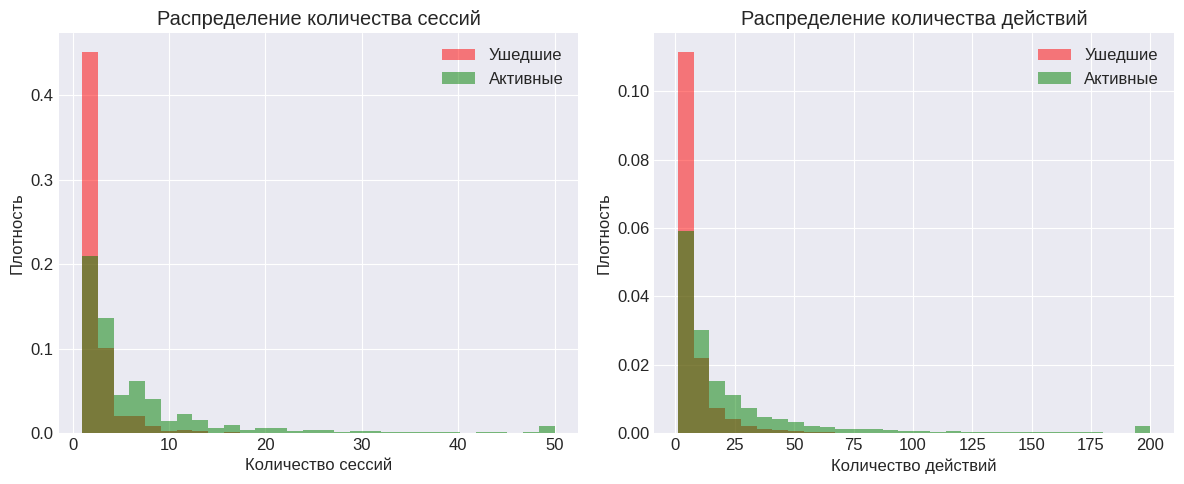


2. АНАЛИЗ ВРЕМЕНИ ЖИЗНИ ПОЛЬЗОВАТЕЛЕЙ:
Среднее время жизни:
  • Ушедшие: 3.8 дней (±6.9)
  • Активные: 22.9 дней (±18.0)
  • Отношение: 6.0x


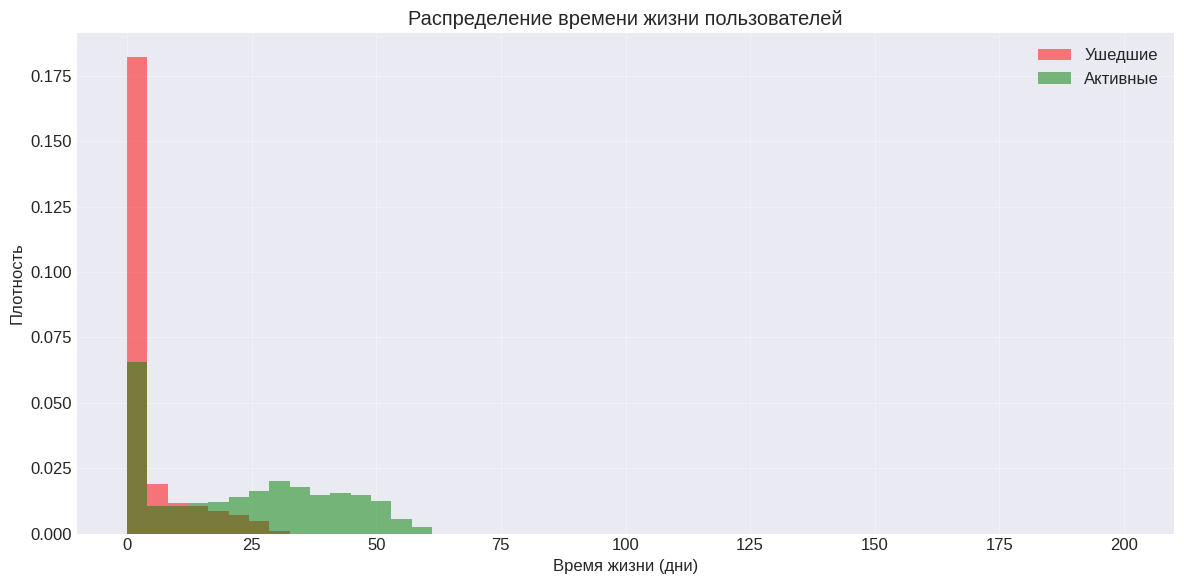


3. АНАЛИЗ АКТИВНОСТИ ПО ВРЕМЕНИ:


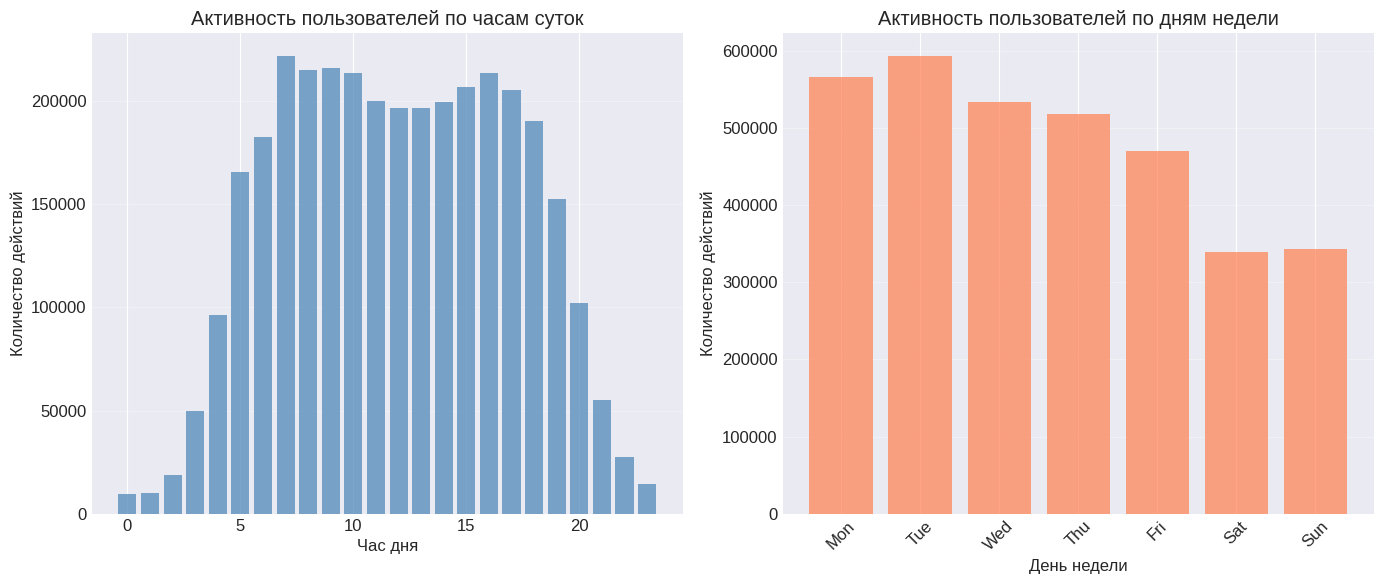

Пиковые часы активности: 7ч (221,756 действий)
Самый активный день: Tuesday (592,750 действий)


In [15]:
print("ПОВЕДЕНЧЕСКИЙ АНАЛИЗ ПОЛЬЗОВАТЕЛЕЙ")

# 1. Анализ частоты использования
print("1. АНАЛИЗ ЧАСТОТЫ ИСПОЛЬЗОВАНИЯ:")

# Количество сессий на пользователя
sessions_per_user_left = df_left.groupby('device_id')['session_id'].nunique()
sessions_per_user_active = df_active.groupby('device_id')['session_id'].nunique()

print(f"Среднее число сессий:")
print(f"  • Ушедшие: {sessions_per_user_left.mean():.1f} (±{sessions_per_user_left.std():.1f})")
print(f"  • Активные: {sessions_per_user_active.mean():.1f} (±{sessions_per_user_active.std():.1f})")
print(f"  • Разница: {sessions_per_user_active.mean() - sessions_per_user_left.mean():.1f} сессий")

# Количество действий на пользователя
actions_per_user_left = df_left.groupby('device_id').size()
actions_per_user_active = df_active.groupby('device_id').size()

print(f"\nСреднее число действий:")
print(f"  • Ушедшие: {actions_per_user_left.mean():.1f} (±{actions_per_user_left.std():.1f})")
print(f"  • Активные: {actions_per_user_active.mean():.1f} (±{actions_per_user_active.std():.1f})")
print(f"  • Разница: {actions_per_user_active.mean() - actions_per_user_left.mean():.1f} действий")

# Визуализация распределения сессий
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(sessions_per_user_left.clip(0, 50), bins=30, alpha=0.5, label='Ушедшие', density=True, color='red')
plt.hist(sessions_per_user_active.clip(0, 50), bins=30, alpha=0.5, label='Активные', density=True, color='green')
plt.xlabel('Количество сессий')
plt.ylabel('Плотность')
plt.title('Распределение количества сессий')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(actions_per_user_left.clip(0, 200), bins=30, alpha=0.5, label='Ушедшие', density=True, color='red')
plt.hist(actions_per_user_active.clip(0, 200), bins=30, alpha=0.5, label='Активные', density=True, color='green')
plt.xlabel('Количество действий')
plt.ylabel('Плотность')
plt.title('Распределение количества действий')
plt.legend()

plt.tight_layout()
plt.show()

# 2. Анализ времени жизни пользователей
print("\n2. АНАЛИЗ ВРЕМЕНИ ЖИЗНИ ПОЛЬЗОВАТЕЛЕЙ:")

# Время жизни пользователей
user_activity = df.groupby('device_id')['event_dt'].agg(['min', 'max']).rename(
    columns={'min': 'first_event', 'max': 'last_event'})
user_activity['lifetime_days'] = (user_activity['last_event'] - user_activity['first_event']).dt.days
user_activity['is_churn'] = user_activity.index.isin(users_left['device_id']).astype(int)

churned_lifetime = user_activity[user_activity['is_churn'] == 1]['lifetime_days']
active_lifetime = user_activity[user_activity['is_churn'] == 0]['lifetime_days']

print(f"Среднее время жизни:")
print(f"  • Ушедшие: {churned_lifetime.mean():.1f} дней (±{churned_lifetime.std():.1f})")
print(f"  • Активные: {active_lifetime.mean():.1f} дней (±{active_lifetime.std():.1f})")
print(f"  • Отношение: {active_lifetime.mean()/max(churned_lifetime.mean(), 0.1):.1f}x")

# Визуализация времени жизни
plt.figure(figsize=(12, 6))
bins = np.linspace(0, 200, 50)

plt.hist(churned_lifetime.clip(0, 200), bins=bins, alpha=0.5,
         label='Ушедшие', density=True, color='red')
plt.hist(active_lifetime.clip(0, 200), bins=bins, alpha=0.5,
         label='Активные', density=True, color='green')
plt.xlabel('Время жизни (дни)')
plt.ylabel('Плотность')
plt.title('Распределение времени жизни пользователей')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Анализ активности по времени суток и дням недели
print("\n3. АНАЛИЗ АКТИВНОСТИ ПО ВРЕМЕНИ:")

df['hour'] = df['event_dt'].dt.hour
df['day_of_week'] = df['event_dt'].dt.day_name()
df['day_of_week_num'] = df['event_dt'].dt.dayofweek

# Активность по часам суток
hourly_activity = df.groupby('hour').size()

# Активность по дням недели
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_activity = df.groupby('day_of_week').size().reindex(days_order)

# Визуализация
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.bar(hourly_activity.index, hourly_activity.values, color='steelblue', alpha=0.7)
plt.xlabel('Час дня')
plt.ylabel('Количество действий')
plt.title('Активность пользователей по часам суток')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
bars = plt.bar(range(len(daily_activity)), daily_activity.values, color='coral', alpha=0.7)
plt.xticks(range(len(daily_activity)), [day[:3] for day in daily_activity.index], rotation=45)
plt.xlabel('День недели')
plt.ylabel('Количество действий')
plt.title('Активность пользователей по дням недели')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Пиковые часы активности: {hourly_activity.idxmax()}ч ({hourly_activity.max():,} действий)")
print(f"Самый активный день: {daily_activity.idxmax()} ({daily_activity.max():,} действий)")

АНАЛИЗ ПОЛЬЗОВАТЕЛЬСКИХ ПУТЕЙ И КРИТИЧЕСКИХ ТОЧЕК

1. АНАЛИЗ ПОСЛЕДНИХ ДЕЙСТВИЙ ПЕРЕД УХОДОМ:

Топ screen в последних 3 действиях перед уходом:
  • Еще                           : 100,850 (67.8%)
  • Важное                        : 22,493 (15.1%)
  • Новая заявка                  : 16,737 (11.3%)
  • Услуги                        :  2,905 (2.0%)
  • Мои баллы                     :  2,580 (1.7%)
  • Новое ОСС                     :  1,214 (0.8%)
  • Объявления                    :    992 (0.7%)
  • Связаться с владельцем ТС     :    963 (0.6%)
  • Гостевой доступ               :     13 (0.0%)
  • Заявки                        :      8 (0.0%)

Топ feature в последних 3 действиях перед уходом:
  • Открытие экрана               : 80,533 (54.1%)
  • Просмотр уведомления          : 22,493 (15.1%)
  • Переход в раздел 'Опросы и собрания собственников': 12,703 (8.5%)
  • Возврат на предыдущий этап    :  3,646 (2.5%)
  • Переход в раздел 'Приборы учета':  3,350 (2.3%)
  • Переход в раздел 'Заявк

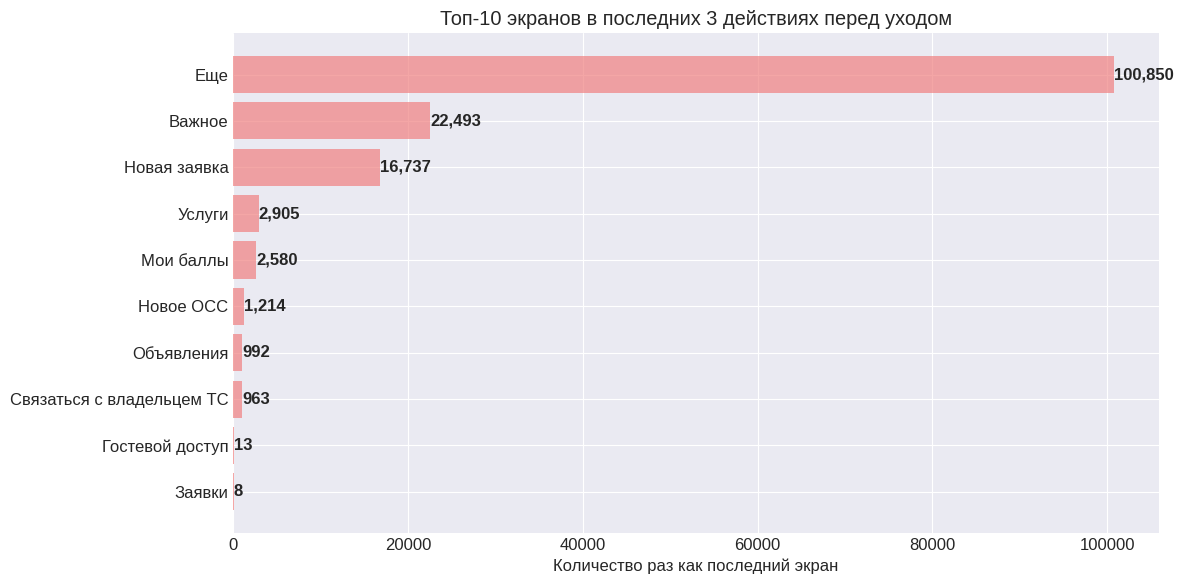


2. АНАЛИЗ ЗАВЕРШЕНИЯ СЕССИЙ (is_finish):

Топ-10 node_id с наибольшим процентом завершений сессий:
  • Мой дом_Переход к удалению адреса на mos.ru: 92.4% (134.0/145.0)
  • Мои баллы_Переход на портал 'Миллион призов': 86.6% (233.0/269.0)
  • Услуги_Выбор услуги партнеров           : 83.9% (120.0/143.0)
  • Мой дом_Звонок в диспетчерскую          : 78.6% (151.0/192.0)
  • Мои баллы_Переход к поощрениям          : 78.3% (4,212.0/5,380.0)
  • Услуги_Выбор услуги партнёров           : 72.6% (236.0/325.0)
  • Новая заявка_Выбор способа подачи заявки: 71.1% (2,741.0/3,854.0)
  • Мои баллы_Распространение промокода     : 66.5% (929.0/1,397.0)
  • Услуги_Выбор услуги городских сервисов  : 61.3% (1,170.0/1,910.0)
  • Еще_Переход в раздел 'Приборы учета'    : 58.3% (38,010.0/65,184.0)

Топ-10 node_id с наименьшим процентом завершений сессий:
  • Новое ОСС_Переход к определению даты начала и продолжительности голосования: 1.6% (5.0/304.0)
  • Еще_Переход в раздел 'Объявления'       : 1.5% (183.0

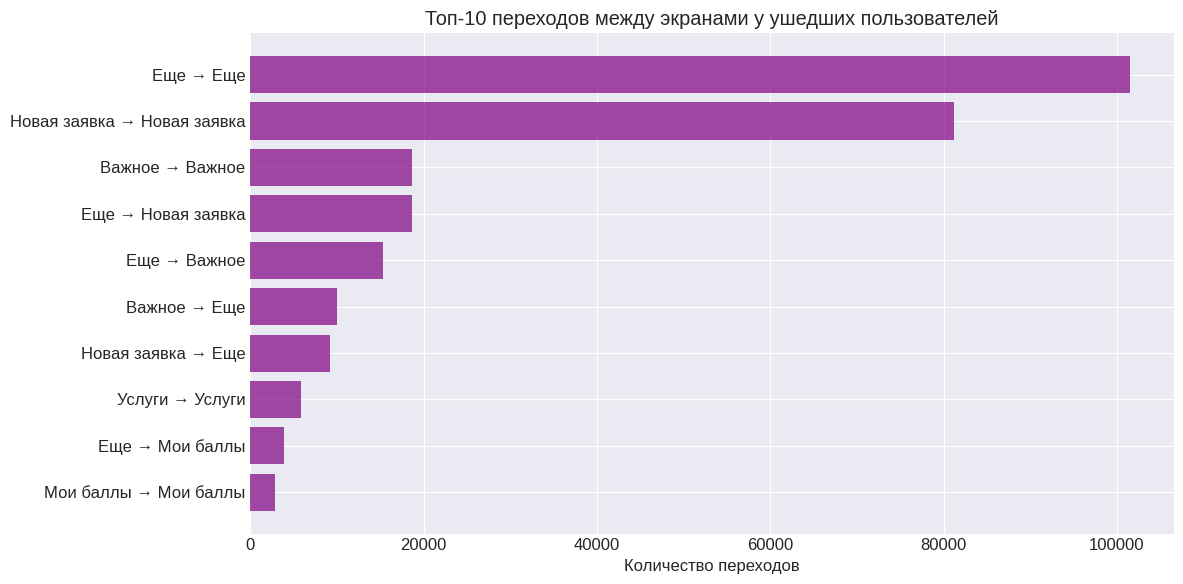

In [16]:
print("АНАЛИЗ ПОЛЬЗОВАТЕЛЬСКИХ ПУТЕЙ И КРИТИЧЕСКИХ ТОЧЕК")

# Анализ последних действий перед уходом
print("\n1. АНАЛИЗ ПОСЛЕДНИХ ДЕЙСТВИЙ ПЕРЕД УХОДОМ:")

# Сортируем данные ушедших пользователей
chains_left = df_left.sort_values(["device_id", 'session_id', 'event_dt'])

# Анализируем последние N действий перед уходом
last_n_actions = 3
last_actions = chains_left.groupby('device_id').tail(last_n_actions)

print(f"\nТоп screen в последних {last_n_actions} действиях перед уходом:")
top_last_screens = last_actions['screen'].value_counts().head(10)
for screen, count in top_last_screens.items():
    percentage = count / len(last_actions) * 100
    print(f"  • {screen:30s}: {count:6,} ({percentage:.1f}%)")

print(f"\nТоп feature в последних {last_n_actions} действиях перед уходом:")
top_last_features = last_actions['feature'].value_counts().head(10)
for feature, count in top_last_features.items():
    percentage = count / len(last_actions) * 100
    print(f"  • {feature:30s}: {count:6,} ({percentage:.1f}%)")

print(f"\nТоп node_id в последних {last_n_actions} действиях перед уходом:")
top_last_nodes = last_actions['node_id'].value_counts().head(10)
for node, count in top_last_nodes.items():
    percentage = count / len(last_actions) * 100
    print(f"  • {node:40s}: {count:6,} ({percentage:.1f}%)")

# Визуализация топ экранов перед уходом
plt.figure(figsize=(12, 6))
top_screens = last_actions['screen'].value_counts().head(10)

bars = plt.barh(range(len(top_screens)), top_screens.values, color='lightcoral', alpha=0.7)
plt.yticks(range(len(top_screens)), top_screens.index)
plt.xlabel('Количество раз как последний экран')
plt.title(f'Топ-10 экранов в последних {last_n_actions} действиях перед уходом')
plt.gca().invert_yaxis()

# Добавляем значения на столбцы
for i, (idx, value) in enumerate(top_screens.items()):
    plt.text(value + 0.1, i, f"{value:,}", va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# 2. Анализ is_finish по разным группам
print("\n2. АНАЛИЗ ЗАВЕРШЕНИЯ СЕССИЙ (is_finish):")

# Группируем по node_id и смотрим процент завершений
node_finish_stats = df.groupby('node_id').agg({
    'is_finish': ['mean', 'count', 'sum']
}).round(3)

node_finish_stats.columns = ['finish_rate', 'total_visits', 'finish_count']
node_finish_stats = node_finish_stats.sort_values('finish_rate', ascending=False)

print("\nТоп-10 node_id с наибольшим процентом завершений сессий:")
top_finish_nodes = node_finish_stats[node_finish_stats['total_visits'] > 100].head(10)
for node, row in top_finish_nodes.iterrows():
    print(f"  • {node:40s}: {row['finish_rate']:.1%} ({row['finish_count']:,}/{row['total_visits']:,})")

print("\nТоп-10 node_id с наименьшим процентом завершений сессий:")
bottom_finish_nodes = node_finish_stats[node_finish_stats['total_visits'] > 100].tail(10)
for node, row in bottom_finish_nodes.iterrows():
    print(f"  • {node:40s}: {row['finish_rate']:.1%} ({row['finish_count']:,}/{row['total_visits']:,})")

# 3. Сравнение finish rate у ушедших и активных пользователей
print("\n3. СРАВНЕНИЕ FINISH RATE У РАЗНЫХ ГРУПП:")

finish_rate_left = df_left['is_finish'].mean()
finish_rate_active = df_active['is_finish'].mean()

print(f"Процент завершений сессий (is_finish=1):")
print(f"  • Ушедшие пользователи: {finish_rate_left:.1%}")
print(f"  • Активные пользователи: {finish_rate_active:.1%}")
print(f"  • Разница: {abs(finish_rate_active - finish_rate_left):.1%}")

# 4. Анализ перехода между экранами
print("\n4. АНАЛИЗ ПЕРЕХОДОВ МЕЖДУ ЭКРАНАМИ:")

# Создаем матрицу переходов для ушедших пользователей
df_sorted = df.sort_values(['device_id', 'session_id', 'event_dt'])

# Добавляем следующий экран
df_sorted['next_screen'] = df_sorted.groupby(['device_id', 'session_id'])['screen'].shift(-1)
df_sorted['next_node'] = df_sorted.groupby(['device_id', 'session_id'])['node_id'].shift(-1)

# Фильтруем только ушедших
transitions_left = df_sorted[df_sorted['is_churn'] == 1].dropna(subset=['next_screen'])

# Топ переходов
print("\nТоп-10 переходов между экранами у ушедших пользователей:")
top_transitions = transitions_left.groupby(['screen', 'next_screen']).size().reset_index(name='count')
top_transitions = top_transitions.sort_values('count', ascending=False).head(10)

for _, row in top_transitions.iterrows():
    print(f"  • {row['screen']} → {row['next_screen']}: {row['count']:,}")

# Визуализация топ переходов
plt.figure(figsize=(12, 6))
plt.barh(range(len(top_transitions)), top_transitions['count'].values,
         color='purple', alpha=0.7)
plt.yticks(range(len(top_transitions)),
           [f"{row['screen']} → {row['next_screen']}" for _, row in top_transitions.iterrows()])
plt.xlabel('Количество переходов')
plt.title('Топ-10 переходов между экранами у ушедших пользователей')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [17]:

print("СТАТИСТИЧЕСКИЕ ТЕСТЫ И КЛЮЧЕВЫЕ ВЫВОДЫ")

# Проверка значимости различий в возрасте
age_left = df_left['age'].dropna()
age_active = df_active['age'].dropna()

if len(age_left) > 0 and len(age_active) > 0:
    t_stat_age, p_val_age = stats.ttest_ind(age_left, age_active, equal_var=False, nan_policy='omit')
    print(f"\n1. Различия в возрасте между ушедшими и активными:")
    print(f"   T-статистика: {t_stat_age:.3f}")
    print(f"   P-значение: {p_val_age:.4f}")
    if p_val_age < 0.05:
        print(f"  Различия СТАТИСТИЧЕСКИ ЗНАЧИМЫ (p < 0.05)")
    else:
        print(f"   Различия не статистически значимы (p ≥ 0.05)")
else:
    print("\n1. Недостаточно данных для проверки различий в возрасте")

# Проверка значимости различий по количеству сессий
if len(sessions_per_user_left) > 0 and len(sessions_per_user_active) > 0:
    t_stat_sessions, p_val_sessions = stats.mannwhitneyu(
        sessions_per_user_left,
        sessions_per_user_active,
        alternative='two-sided'
    )
    print(f"\n2. Различия в количестве сессий:")
    print(f"   U-статистика Манна-Уитни: {t_stat_sessions:.3f}")
    print(f"   P-значение: {p_val_sessions:.4f}")
    if p_val_sessions < 0.05:
        print(f"   Различия СТАТИСТИЧЕСКИ ЗНАЧИМЫ (p < 0.05)")
    else:
        print(f"   Различия не статистически значимы (p ≥ 0.05)")
else:
    print("\n2. Недостаточно данных для проверки различий в сессиях")

# Проверка связи ОС с оттоком
os_contingency = pd.crosstab(df['os'], df['is_churn'])
if os_contingency.shape[0] > 1 and os_contingency.shape[1] > 1:
    chi2_os, p_val_os, dof_os, expected_os = stats.chi2_contingency(os_contingency)
    print(f"\n3. Связь операционной системы с оттоком:")
    print(f"   Хи-квадрат: {chi2_os:.3f}")
    print(f"   P-значение: {p_val_os:.4f}")
    if p_val_os < 0.05:
        print(f"   Связь СТАТИСТИЧЕСКИ ЗНАЧИМА (p < 0.05)")
    else:
        print(f"   Связь не статистически значима (p ≥ 0.05)")
else:
    print("\n3. Недостаточно данных для проверки связи ОС с оттоком")

print("\n2. КЛЮЧЕВЫЕ ВЫВОДЫ:")

# Собираем ключевые метрики
summary_metrics = {
    'Общий процент оттока': f"{df['is_churn'].mean()*100:.1f}%",
    'Среднее время жизни (ушедшие)': f"{churned_lifetime.mean():.1f} дней",
    'Среднее время жизни (активные)': f"{active_lifetime.mean():.1f} дней",
    'Разница в сессиях': f"{sessions_per_user_active.mean() - sessions_per_user_left.mean():.1f}",
    'Разница в действиях': f"{actions_per_user_active.mean() - actions_per_user_left.mean():.1f}",
    'Процент завершений сессий': f"{df['is_finish'].mean()*100:.1f}%",
    'Пропуски в action': f"{df['action'].isna().mean()*100:.1f}%"
}

print("\nКЛЮЧЕВЫЕ МЕТРИКИ:")
for metric, value in summary_metrics.items():
    print(f"  • {metric}: {value}")

print("\nКРИТИЧЕСКИЕ ТОЧКИ:")
critical_points = [
    "1. Короткое время жизни ушедших пользователей",
    "2. Значительно меньше сессий и действий у ушедших",
    "3. Конкретные модели устройств с высоким оттоком",
    f"4. {top_last_screens.index[0]} - самый частый последний экран",
    f"5. {top_finish_nodes.index[0]} - самый высокий finish rate",
    "6. Разница в активности по времени суток"
]

for point in critical_points:
    print(f"  • {point}")



# Сохранение результатов анализа
print("СОХРАНЕНИЕ РЕЗУЛЬТАТОВ")


try:
    # Создаем сводную таблицу результатов
    results = {
        'age_churn': age_churn_df,
        'gender_churn': gender_churn_df,
        'os_churn': os_churn_df,
        'device_churn': device_churn_df,
        'top_problem_models': high_churn_models.head(20) if len(high_churn_models) > 0 else pd.DataFrame(),
        'top_last_screens': pd.DataFrame(top_last_screens.head(20)),
        'node_finish_stats': node_finish_stats.head(20)
    }

    # Создаем Excel файл с несколькими листами
    output_path = 'churn_analysis_results.xlsx'
    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        for sheet_name, df_result in results.items():
            sheet_name_short = sheet_name[:31]  # Excel максимум 31 символ
            df_result.to_excel(writer, sheet_name=sheet_name_short)

    print(f"Результаты анализа сохранены в Excel файл: {output_path}")

except Exception as e:
    print(f"Ошибка при сохранении результатов: {e}")
    print("Продолжаем выполнение анализа...")


print("АНАЛИЗ УСПЕШНО ЗАВЕРШЕН")


СТАТИСТИЧЕСКИЕ ТЕСТЫ И КЛЮЧЕВЫЕ ВЫВОДЫ

1. Различия в возрасте между ушедшими и активными:
   T-статистика: -70.025
   P-значение: 0.0000
  Различия СТАТИСТИЧЕСКИ ЗНАЧИМЫ (p < 0.05)

2. Различия в количестве сессий:
   U-статистика Манна-Уитни: 1829702767.500
   P-значение: 0.0000
   Различия СТАТИСТИЧЕСКИ ЗНАЧИМЫ (p < 0.05)

3. Связь операционной системы с оттоком:
   Хи-квадрат: 7998.566
   P-значение: 0.0000
   Связь СТАТИСТИЧЕСКИ ЗНАЧИМА (p < 0.05)

2. КЛЮЧЕВЫЕ ВЫВОДЫ:

КЛЮЧЕВЫЕ МЕТРИКИ:
  • Общий процент оттока: 12.9%
  • Среднее время жизни (ушедшие): 3.8 дней
  • Среднее время жизни (активные): 22.9 дней
  • Разница в сессиях: 5.0
  • Разница в действиях: 18.0
  • Процент завершений сессий: 29.8%
  • Пропуски в action: 52.5%

КРИТИЧЕСКИЕ ТОЧКИ:
  • 1. Короткое время жизни ушедших пользователей
  • 2. Значительно меньше сессий и действий у ушедших
  • 3. Конкретные модели устройств с высоким оттоком
  • 4. Еще - самый частый последний экран
  • 5. Мой дом_Переход к удалению адрес

АНАЛИЗ ПОСЛЕДОВАТЕЛЬНОСТЕЙ И ПОВЕДЕНЧЕСКИХ ПАТТЕРНОВ

1. ТИПИЧНЫЕ ПУТИ ПОЛЬЗОВАТЕЛЕЙ:

Топ-10 первых действий в сессии:
  • Еще_Открытие экрана                     : 866,745 (86.5%)
  • Важное_Просмотр уведомления             : 70,392 (7.0%)
  • Мой дом_Открытие экрана                 : 15,100 (1.5%)
  • Новая заявка_Выбор через теги           :  8,432 (0.8%)
  • Заявки_Открытие экрана                  :  7,215 (0.7%)
  • Новая заявка_Выбор квартиры             :  6,963 (0.7%)
  • Новая заявка_Открытие экрана            :  4,963 (0.5%)
  • Услуги_Открытие экрана                  :  3,924 (0.4%)
  • Новая заявка_Выбор актуальной темы      :  2,981 (0.3%)
  • Новая заявка_Выбор объекта заявки       :  2,454 (0.2%)

Топ-10 последовательностей из 2 действий:
  • Еще_Открытие экрана → Еще_Переход в раздел 'Заявки': 150,934
  • Еще_Открытие экрана → Еще_Переход в раздел 'Опросы и собрания собственников': 109,572
  • Важное_Просмотр уведомления → Важное_Просмотр уведомления: 90,145
  • Заявки

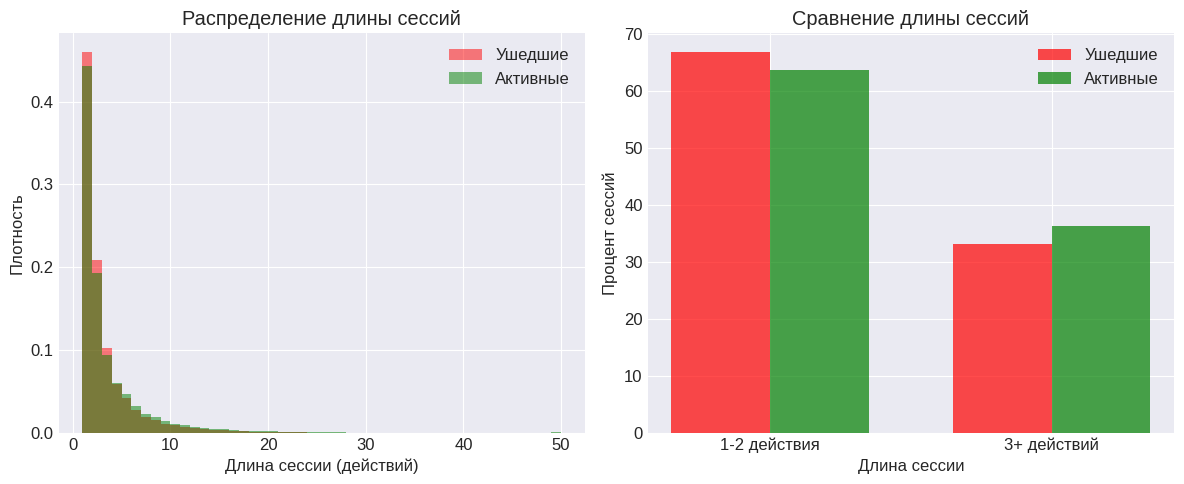

In [18]:

print("АНАЛИЗ ПОСЛЕДОВАТЕЛЬНОСТЕЙ И ПОВЕДЕНЧЕСКИХ ПАТТЕРНОВ")

# 1. Анализ типичных путей пользователей
print("\n1. ТИПИЧНЫЕ ПУТИ ПОЛЬЗОВАТЕЛЕЙ:")

# Создаем последовательности действий для каждого пользователя в сессии
df_sorted = df.sort_values(['device_id', 'session_id', 'event_dt'])

# Добавляем порядковый номер действия в сессии
df_sorted['action_order'] = df_sorted.groupby(['device_id', 'session_id']).cumcount() + 1

# Анализ наиболее частых первых действий
print("\nТоп-10 первых действий в сессии:")
first_actions = df_sorted[df_sorted['action_order'] == 1]
first_actions_summary = first_actions['node_id'].value_counts().head(10)

for node, count in first_actions_summary.items():
    percentage = count / len(first_actions) * 100
    print(f"  • {node:40s}: {count:6,} ({percentage:.1f}%)")

# Анализ последовательностей из 2-3 действий
print("\nТоп-10 последовательностей из 2 действий:")
sequences_2 = df_sorted.groupby(['device_id', 'session_id']).apply(
    lambda x: list(zip(x['node_id'].iloc[:-1], x['node_id'].iloc[1:]))
).explode()

if len(sequences_2) > 0:
    top_sequences_2 = sequences_2.value_counts().head(10)
    for seq, count in top_sequences_2.items():
        print(f"  • {seq[0]} → {seq[1]}: {count:,}")

# 2. Анализ глубины сессий
print("\n2. ГЛУБИНА СЕССИЙ:")

# Длина сессий (количество действий)
session_lengths = df_sorted.groupby(['device_id', 'session_id']).size()
session_lengths_left = df_sorted[df_sorted['is_churn'] == 1].groupby(['device_id', 'session_id']).size()
session_lengths_active = df_sorted[df_sorted['is_churn'] == 0].groupby(['device_id', 'session_id']).size()

print(f"Средняя длина сессии:")
print(f"  • Все: {session_lengths.mean():.1f} действий")
print(f"  • Ушедшие: {session_lengths_left.mean():.1f} действий")
print(f"  • Активные: {session_lengths_active.mean():.1f} действий")

# Распределение длины сессий
plt.figure(figsize=(12, 5))
bins = range(1, 51)

plt.subplot(1, 2, 1)
plt.hist(session_lengths_left.clip(1, 50), bins=bins, alpha=0.5,
         label='Ушедшие', density=True, color='red')
plt.hist(session_lengths_active.clip(1, 50), bins=bins, alpha=0.5,
         label='Активные', density=True, color='green')
plt.xlabel('Длина сессии (действий)')
plt.ylabel('Плотность')
plt.title('Распределение длины сессий')
plt.legend()

plt.subplot(1, 2, 2)
# Процент коротких сессий (1-2 действия)
short_sessions_left = (session_lengths_left <= 2).mean() * 100
short_sessions_active = (session_lengths_active <= 2).mean() * 100

categories = ['1-2 действия', '3+ действий']
left_values = [short_sessions_left, 100 - short_sessions_left]
active_values = [short_sessions_active, 100 - short_sessions_active]

x = np.arange(len(categories))
width = 0.35

plt.bar(x - width/2, left_values, width, label='Ушедшие', color='red', alpha=0.7)
plt.bar(x + width/2, active_values, width, label='Активные', color='green', alpha=0.7)
plt.xlabel('Длина сессии')
plt.ylabel('Процент сессий')
plt.title('Сравнение длины сессий')
plt.xticks(x, categories)
plt.legend()

plt.tight_layout()
plt.show()


In [19]:

print("АНАЛИЗ ДОСТУПНЫХ ДЕЙСТВИЙ И ВОРОНКИ")

# 1. Смотрим все уникальные действия в данных
print("1. ВСЕ УНИКАЛЬНЫЕ ДЕЙСТВИЯ В ДАННЫХ:")


all_actions = df['action'].dropna().unique()
print(f"Всего уникальных действий: {len(all_actions)}")
print("\nПервые 50 уникальных действий:")
for i, action in enumerate(all_actions[:50]):
    print(f"  {i+1:2d}. {action}")

АНАЛИЗ ДОСТУПНЫХ ДЕЙСТВИЙ И ВОРОНКИ
1. ВСЕ УНИКАЛЬНЫЕ ДЕЙСТВИЯ В ДАННЫХ:
Всего уникальных действий: 316

Первые 50 уникальных действий:
   1. Тап на кнопку 'Заявки'
   2. Тап на кнопку 'Мои платежи'
   3. Тап на кнопку 'Услуги'
   4. Тап на уведомление
   5. Выбор тега 1
   6. Выбор темы через теги
   7. Управление освещением подъезда
   8. Неисправность элементов освещения дома
   9. Тап на кнопку 'Создать заявку'
  10. Тап на кнопку 'Мой транспорт'
  11. Тап на кнопку 'Приборы учёта'
  12. Тап на кнопку 'Городские сервисы'
  13. Тап на кнопку 'Обращения в УО'
  14. Тап на кнопку 'Соседей'
  15. Тап на заявку
  16. Тап на стрелку назад
  17. Тап на кнопку 'Профиль'
  18. Тап на кнопку 'Опросы и собрания собственников'
  19. Тап на кнопку 'Мои баллы'
  20. Тап на кнопку 'Перейти'
  21. Отсутствует горячая и холодная вода (ГВС и ХВС)
  22. Открытие экрана
  23. Тап на кнопку 'Объявления'
  24. Тап на квартиру
  25. Тап на кнопку 'Подтвердить выполнение'
  26. Тап на кнопку 'Мои'
  27. Т

In [ ]:
# 2. Топ-20 самых частых действий
print("\n2. ТОП-20 САМЫХ ЧАСТЫХ ДЕЙСТВИЙ:")


action_counts = df['action'].value_counts()
print(f"Всего записей с действиями: {action_counts.sum():,}")
print(f"Пропусков в action: {df['action'].isna().sum():,} ({df['action'].isna().mean()*100:.1f}%)")

for action, count in action_counts.head(20).items():
    percentage = count / len(df) * 100
    print(f"  • {action:40s}: {count:8,} ({percentage:.1f}%)")


2. ТОП-20 САМЫХ ЧАСТЫХ ДЕЙСТВИЙ:
Всего записей с действиями: 1,595,274
Пропусков в action: 1,765,376 (52.5%)
  • Тап на уведомление                      :  234,474 (7.0%)
  • Тап на кнопку 'Заявки'                  :  200,179 (6.0%)
  • Тап на стрелку назад                    :  141,793 (4.2%)
  • Тап на кнопку 'Опросы и собрания собственников':  126,429 (3.8%)
  • Тап на заявку                           :   87,227 (2.6%)
  • Тап на кнопку 'Мои платежи'             :   58,452 (1.7%)
  • выбор тега 1                            :   57,488 (1.7%)
  • Тап на кнопку 'Создать заявку'          :   56,410 (1.7%)
  • Тап на кнопку поиска                    :   54,895 (1.6%)
  • Тап на кнопку 'Соседей'                 :   43,188 (1.3%)
  • Тап на кнопку 'Приборы учёта'           :   42,017 (1.3%)
  • Тап на квартиру                         :   41,818 (1.2%)
  • Тап на категорию                        :   30,159 (0.9%)
  • Выбор тега 1                            :   29,507 (0.9%)
  • Тап на кноп


3. КАТЕГОРИЗАЦИЯ ДЕЙСТВИЙ:

Распределение по категориям действий:
  • Другое                   : 1,595,274.0 (47.5%), отток: 14.3%
  • Не указано               :      0.0 (0.0%), отток: 11.6%

4. ВОРОНКА КЛЮЧЕВЫХ ДЕЙСТВИЙ:

Строим воронку для 10 самых частых действий:

Действие                                 Всего      Ушедшие    Активные   Отток,%    Категория      
Тап на уведомление                       234,474    49,052     185,422    20.9       Другое         
Тап на кнопку 'Заявки'                   200,179    16,142     184,037    8.1        Другое         
Тап на стрелку назад                     141,793    22,209     119,584    15.7       Другое         
Тап на кнопку 'Опросы и собрания собственников' 126,429    30,159     96,270     23.9       Другое         
Тап на заявку                            87,227     23         87,204     0.0        Другое         
Тап на кнопку 'Мои платежи'              58,452     4,942      53,510     8.5        Другое         
выбор тега 1   

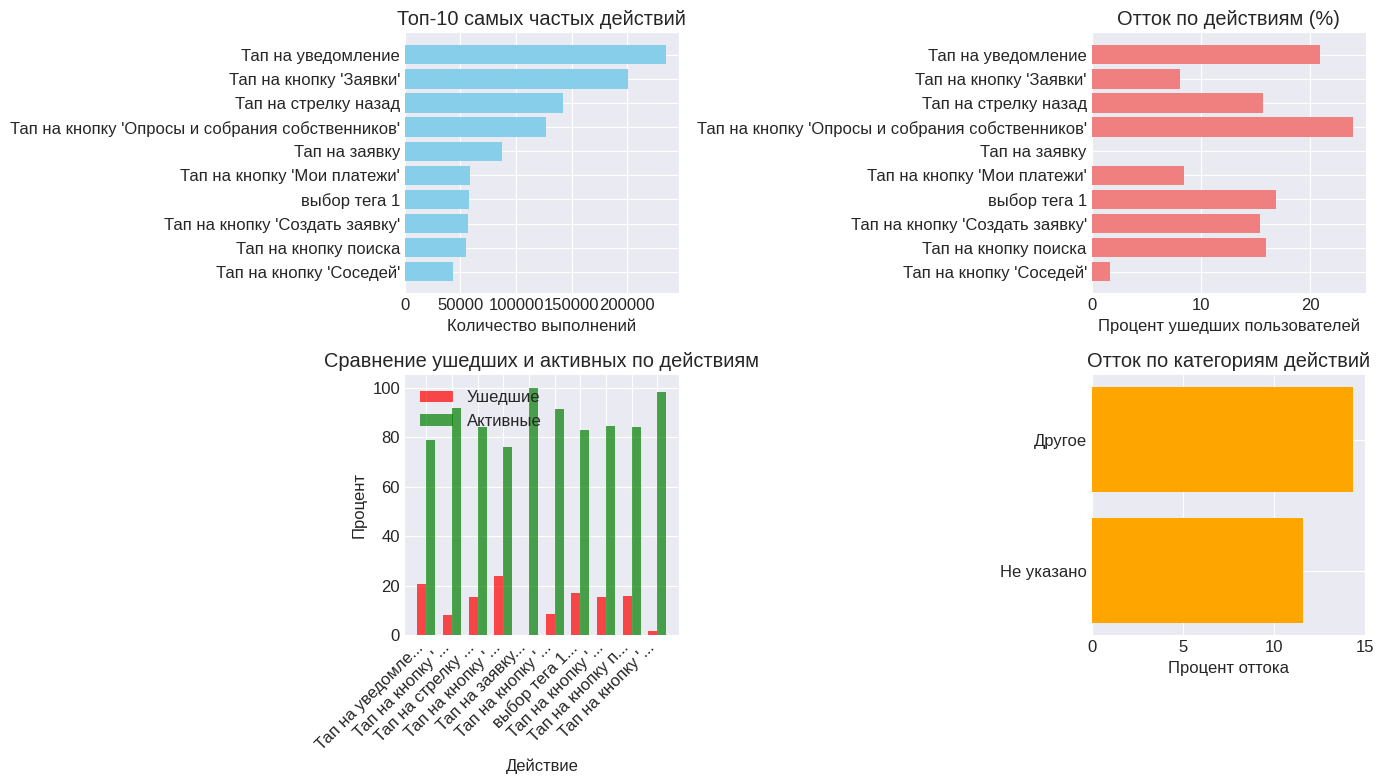

In [22]:
# 3. Анализируем распределение действий по группам
print("\n3. КАТЕГОРИЗАЦИЯ ДЕЙСТВИЙ:")

# Сначала подсчитаем частоту действий (это нужно добавить перед кодом воронки)
action_counts = df['action'].value_counts()

# Попробуем автоматически определить категории действий
def categorize_action(action):
    if pd.isna(action):
        return 'Не указано'

    action_lower = str(action).lower()

    # Навигационные действия
    if any(word in action_lower for word in ['open', 'close', 'click', 'tap', 'press', 'select', 'choose']):
        return 'Навигация'
    # Поисковые действия
    elif any(word in action_lower for word in ['search', 'find', 'query', 'filter']):
        return 'Поиск'
    # Социальные действия
    elif any(word in action_lower for word in ['like', 'share', 'comment', 'rate', 'review']):
        return 'Социальное взаимодействие'
    # Транзакционные действия
    elif any(word in action_lower for word in ['buy', 'purchase', 'order', 'pay', 'add_to_cart', 'checkout']):
        return 'Покупка/Оплата'
    # Информационные действия
    elif any(word in action_lower for word in ['view', 'read', 'watch', 'show', 'display']):
        return 'Просмотр'
    # Редактирование
    elif any(word in action_lower for word in ['edit', 'update', 'modify', 'change', 'delete', 'remove']):
        return 'Редактирование'
    # Сохранение
    elif any(word in action_lower for word in ['save', 'bookmark', 'favorite', 'download']):
        return 'Сохранение'
    else:
        return 'Другое'

df['action_category'] = df['action'].apply(categorize_action)

# Анализ категорий действий
category_analysis = df.groupby('action_category').agg({
    'action': 'count',
    'is_churn': 'mean'
}).rename(columns={'action': 'count', 'is_churn': 'churn_rate'}).sort_values('count', ascending=False)

print("\nРаспределение по категориям действий:")
for category, row in category_analysis.iterrows():
    print(f"  • {category:25s}: {row['count']:8,} ({row['count']/len(df)*100:.1f}%), "
          f"отток: {row['churn_rate']*100:.1f}%")

# 4. Строим воронку на основе самых частых действий
print("\n4. ВОРОНКА КЛЮЧЕВЫХ ДЕЙСТВИЙ:")

# Выбираем топ-N самых частых действий для воронки
top_n_actions = 10
top_actions = action_counts.head(top_n_actions).index.tolist()

print(f"\nСтроим воронку для {top_n_actions} самых частых действий:")

funnel_data = []
for action in top_actions:
    # Считаем метрики для каждого действия
    action_data = df[df['action'] == action]
    total = len(action_data)

    if total > 0:
        left = len(action_data[action_data['is_churn'] == 1])
        active = len(action_data[action_data['is_churn'] == 0])
        left_pct = left / total * 100
        active_pct = active / total * 100

        funnel_data.append({
            'action': action,
            'total': total,
            'left': left,
            'active': active,
            'left_pct': left_pct,
            'active_pct': active_pct,
            'category': categorize_action(action)
        })

funnel_df = pd.DataFrame(funnel_data).sort_values('total', ascending=False)

# Выводим воронку
print(f"\n{'Действие':<40} {'Всего':<10} {'Ушедшие':<10} {'Активные':<10} {'Отток,%':<10} {'Категория':<15}")

for _, row in funnel_df.iterrows():
    print(f"{row['action']:<40} {row['total']:<10,} {row['left']:<10,} {row['active']:<10,} "
          f"{row['left_pct']:<10.1f} {row['category']:<15}")

# 5. Визуализация воронки
plt.figure(figsize=(14, 8))

# График 1: Распределение действий
plt.subplot(2, 2, 1)
plt.barh(range(len(funnel_df)), funnel_df['total'], color='skyblue')
plt.yticks(range(len(funnel_df)), funnel_df['action'])
plt.xlabel('Количество выполнений')
plt.title('Топ-10 самых частых действий')
plt.gca().invert_yaxis()

# График 2: Отток по действиям
plt.subplot(2, 2, 2)
plt.barh(range(len(funnel_df)), funnel_df['left_pct'], color='lightcoral')
plt.yticks(range(len(funnel_df)), funnel_df['action'])
plt.xlabel('Процент ушедших пользователей')
plt.title('Отток по действиям (%)')
plt.gca().invert_yaxis()

# График 3: Сравнение оттока и активности
plt.subplot(2, 2, 3)
x = np.arange(len(funnel_df))
width = 0.35

plt.bar(x - width/2, funnel_df['left_pct'], width, label='Ушедшие', color='red', alpha=0.7)
plt.bar(x + width/2, funnel_df['active_pct'], width, label='Активные', color='green', alpha=0.7)
plt.xlabel('Действие')
plt.ylabel('Процент')
plt.title('Сравнение ушедших и активных по действиям')
plt.xticks(x, [a[:15] + '...' for a in funnel_df['action']], rotation=45, ha='right')
plt.legend()

# График 4: Отток по категориям действий
plt.subplot(2, 2, 4)
category_churn = df.groupby('action_category')['is_churn'].mean() * 100
category_churn_sorted = category_churn.sort_values(ascending=False)

plt.barh(range(len(category_churn_sorted)), category_churn_sorted.values, color='orange')
plt.yticks(range(len(category_churn_sorted)), category_churn_sorted.index)
plt.xlabel('Процент оттока')
plt.title('Отток по категориям действий')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


5. АНАЛИЗ ПОСЛЕДОВАТЕЛЬНОСТЕЙ КЛЮЧЕВЫХ ДЕЙСТВИЙ:

Анализ последовательности: ['Тап на уведомление', "Тап на кнопку 'Заявки'", 'Тап на стрелку назад']

Пользователей с последовательностью ['Тап на уведомление', "Тап на кнопку 'Заявки'", 'Тап на стрелку назад']: 3,402
Отток среди этих пользователей: 15.1%
Общий отток в данных: 12.9%
Пользователи с этой последовательностью уходят ЧАЩЕ!

6. КОРРЕЛЯЦИЯ ДЕЙСТВИЙ С ОТТОКОМ:

Нет действий с положительной корреляцией с оттоком
Все действия либо снижают вероятность оттока, либо не влияют на него

Действия с наибольшей ОТРИЦАТЕЛЬНОЙ корреляцией с оттоком (реже уходят):
  • Тап на заявку                           : corr=-0.204, пользователей: 13,097
  • Тап на кнопку 'Соседей'                 : corr=-0.181, пользователей: 13,361
  • Тап на кнопку 'Заявки'                  : corr=-0.154, пользователей: 35,408
  • Тап на уведомление                      : corr=-0.139, пользователей: 84,741
  • Тап на кнопку 'Мои платежи'             : corr=-0.135, 

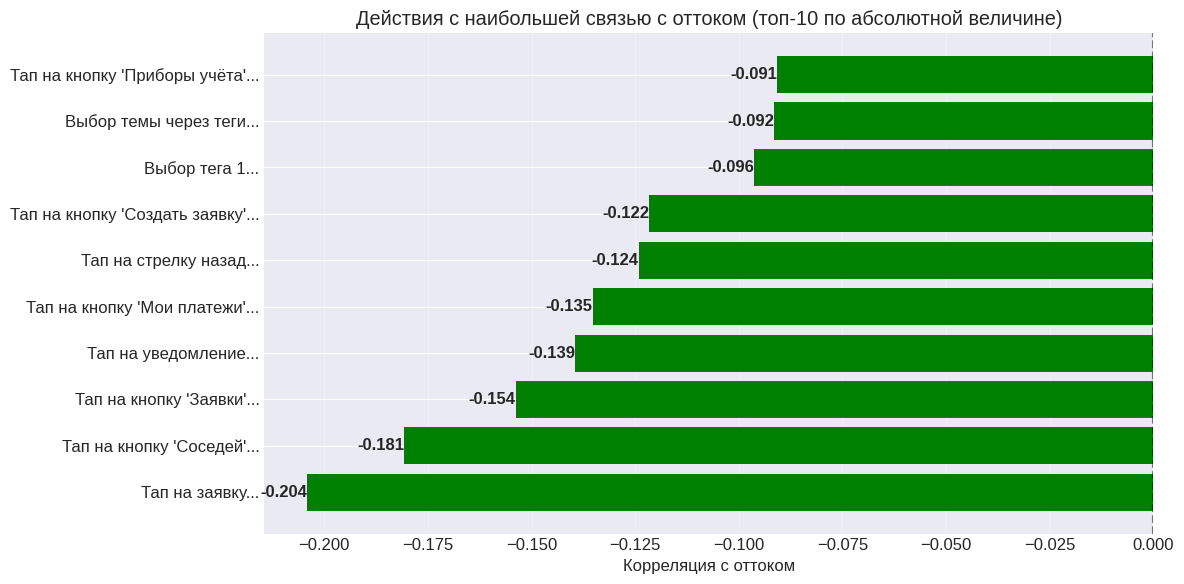

ВЫВОДЫ ПО АНАЛИЗУ ДЕЙСТВИЙ:
  • 1. Обнаружено 316 уникальных действий в данных
  • 2. Топ-1 действие: 'Тап на уведомление' (234,474 раз)
  • 3. Самые частые категории: Другое, Не указано
  • 4. Наибольший отток в категории: Другое (14.3%)
  • 5. Наибольшая отрицательная корреляция: 'Тап на заявку' (corr=-0.204)
  • 6. Последовательность ['Тап на уведомление', "Тап на кнопку 'Заявки'"]... увеличивает отток на 2.2%
  • 7. Наибольший отток после действия: 'Тап на кнопку 'Опросы и собран...' (23.9%)
  • 8. Наименьший отток после действия: 'Тап на заявку...' (0.0%)


In [23]:
print("\n5. АНАЛИЗ ПОСЛЕДОВАТЕЛЬНОСТЕЙ КЛЮЧЕВЫХ ДЕЙСТВИЙ:")

# Выбираем 3 самых важных действий
if len(top_actions) >= 3:
    key_action_sequence = top_actions[:3]
    print(f"\nАнализ последовательности: {key_action_sequence}")

    # Ищем пользователей, которые выполнили эту последовательность
    users_with_sequence = []

    for device_id, user_data in df.sort_values(['device_id', 'event_dt']).groupby('device_id'):
        user_actions = user_data['action'].tolist()

        # Проверяем, содержит ли пользователь все действия из последовательности
        has_all_actions = all(action in user_actions for action in key_action_sequence)

        if has_all_actions:
            # Проверяем порядок (простая проверка)
            indices = [user_actions.index(action) for action in key_action_sequence if action in user_actions]
            if indices == sorted(indices):  # Действия в правильном порядке
                users_with_sequence.append({
                    'device_id': device_id,
                    'is_churn': user_data['is_churn'].iloc[0],
                    'total_actions': len(user_actions)
                })

    if users_with_sequence:
        seq_df = pd.DataFrame(users_with_sequence)
        total_users_with_seq = len(seq_df)
        churn_rate_seq = seq_df['is_churn'].mean() * 100

        print(f"\nПользователей с последовательностью {key_action_sequence}: {total_users_with_seq:,}")
        print(f"Отток среди этих пользователей: {churn_rate_seq:.1f}%")
        print(f"Общий отток в данных: {df['is_churn'].mean()*100:.1f}%")

        if churn_rate_seq < df['is_churn'].mean()*100:
            print("Пользователи с этой последовательностью уходят РЕЖЕ!")
        else:
            print("Пользователи с этой последовательностью уходят ЧАЩЕ!")
    else:
        print("Не найдено пользователей с полной последовательностью")
else:
    print("Недостаточно действий для анализа последовательности")

print("\n6. КОРРЕЛЯЦИЯ ДЕЙСТВИЙ С ОТТОКОМ:")

# Создаем бинарные признаки для топ-20 действий
top_actions_for_corr = action_counts.head(20).index.tolist()

# Создаем таблицу: пользователь × наличие действия
user_action_matrix = []

for device_id, user_data in df.groupby('device_id'):
    user_actions = set(user_data['action'].dropna().unique())
    user_row = {'device_id': device_id, 'is_churn': user_data['is_churn'].iloc[0]}

    for action in top_actions_for_corr:
        user_row[f'has_{action[:20]}'] = 1 if action in user_actions else 0

    user_action_matrix.append(user_row)

action_corr_df = pd.DataFrame(user_action_matrix)

# Считаем корреляцию с оттоком
correlations = []
for action in top_actions_for_corr:
    col_name = f'has_{action[:20]}'
    if col_name in action_corr_df.columns:
        corr = action_corr_df[col_name].corr(action_corr_df['is_churn'])
        correlations.append({
            'action': action,
            'correlation': corr,
            'users_with_action': action_corr_df[col_name].sum()
        })

corr_df = pd.DataFrame(correlations).sort_values('correlation')

# Проверяем наличие положительных корреляций
positive_corr = corr_df[corr_df['correlation'] > 0]
negative_corr = corr_df[corr_df['correlation'] < 0]

if len(positive_corr) > 0:
    print("\nДействия с наибольшей ПОЛОЖИТЕЛЬНОЙ корреляцией с оттоком (чаще уходят):")
    for _, row in positive_corr.tail(5).iterrows():
        print(f"  • {row['action']:40s}: corr={row['correlation']:.3f}, "
              f"пользователей: {row['users_with_action']:,}")
else:
    print("\nНет действий с положительной корреляцией с оттоком")
    print("Все действия либо снижают вероятность оттока, либо не влияют на него")

if len(negative_corr) > 0:
    print("\nДействия с наибольшей ОТРИЦАТЕЛЬНОЙ корреляцией с оттоком (реже уходят):")
    for _, row in negative_corr.head(5).iterrows():
        print(f"  • {row['action']:40s}: corr={row['correlation']:.3f}, "
              f"пользователей: {row['users_with_action']:,}")

# Визуализация корреляций
plt.figure(figsize=(12, 6))

if len(corr_df) > 0:
    # Берем топ-10 действий по абсолютной величине корреляции
    top_correlations = corr_df.reindex(corr_df['correlation'].abs().sort_values(ascending=False).index).head(10)

    colors = ['red' if c > 0 else 'green' for c in top_correlations['correlation']]
    bars = plt.barh(range(len(top_correlations)), top_correlations['correlation'], color=colors)
    plt.yticks(range(len(top_correlations)), [a[:30] + '...' for a in top_correlations['action']])
    plt.xlabel('Корреляция с оттоком')
    plt.title('Действия с наибольшей связью с оттоком (топ-10 по абсолютной величине)')
    plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    plt.grid(axis='x', alpha=0.3)

    # Добавляем значения на график
    for i, (bar, corr) in enumerate(zip(bars, top_correlations['correlation'])):
        plt.text(corr, i, f'{corr:.3f}',
                ha='left' if corr > 0 else 'right',
                va='center',
                fontweight='bold')

    plt.tight_layout()
    plt.show()

print("ВЫВОДЫ ПО АНАЛИЗУ ДЕЙСТВИЙ:")

# Создаем безопасные инсайты
insights = [
    f"1. Обнаружено {len(all_actions)} уникальных действий в данных",
    f"2. Топ-1 действие: '{action_counts.index[0]}' ({action_counts.iloc[0]:,} раз)",
    f"3. Самые частые категории: {category_analysis.index[0]}, {category_analysis.index[1]}",
    f"4. Наибольший отток в категории: {category_churn_sorted.index[0]} ({category_churn_sorted.iloc[0]:.1f}%)",
]

if len(negative_corr) > 0:
    best_action = negative_corr.iloc[0]
    insights.append(f"5. Наибольшая отрицательная корреляция: '{best_action['action']}' (corr={best_action['correlation']:.3f})")

if 'seq_df' in locals():
    insights.append(f"6. Последовательность {key_action_sequence[:2]}... увеличивает отток на {abs(churn_rate_seq - df['is_churn'].mean()*100):.1f}%")

if 'funnel_df' in locals() and len(funnel_df) > 0:
    highest_churn_action = funnel_df.loc[funnel_df['left_pct'].idxmax()]
    lowest_churn_action = funnel_df.loc[funnel_df['left_pct'].idxmin()]
    insights.append(f"7. Наибольший отток после действия: '{highest_churn_action['action'][:30]}...' ({highest_churn_action['left_pct']:.1f}%)")
    insights.append(f"8. Наименьший отток после действия: '{lowest_churn_action['action'][:30]}...' ({lowest_churn_action['left_pct']:.1f}%)")

for insight in insights:
    print(f"  • {insight}")

АНАЛИЗ УДЕРЖАНИЯ И ЖИЗНЕННОГО ЦИКЛА

1. АНАЛИЗ УДЕРЖАНИЯ ПО КОГОРТАМ:

Размеры когорт по месяцам:
  • 2025-08: 311 пользователей
  • 2025-09: 135,609 пользователей
  • 2025-10: 44,056 пользователей

2. АКТИВНОСТЬ ПО ДНЯМ С ПЕРВОГО ВИЗИТА:

Активность в первые 7 дней:
  • День 0: 179,976 пользователей, отток 29.2%
  • День 1: 23,761 пользователей, отток 19.6%
  • День 2: 19,307 пользователей, отток 18.4%
  • День 3: 17,024 пользователей, отток 15.8%
  • День 4: 15,194 пользователей, отток 15.1%
  • День 5: 14,517 пользователей, отток 14.5%
  • День 6: 15,249 пользователей, отток 13.8%
  • День 7: 14,620 пользователей, отток 12.7%


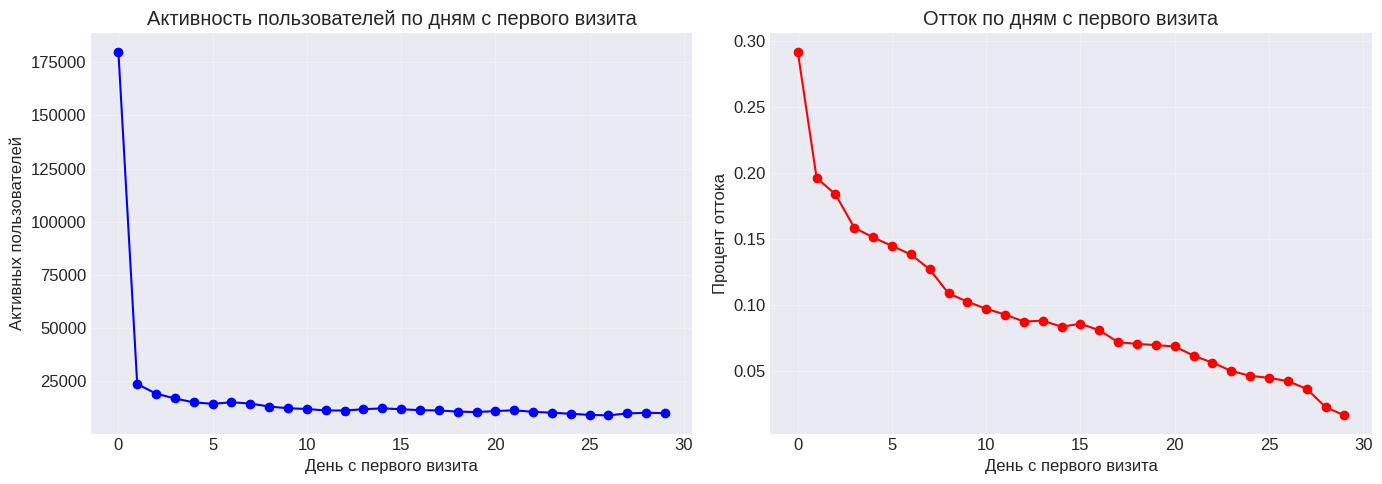


3. 'СМЕРТЕЛЬНЫЕ' ДНИ (ПИКИ ОТТОКА):

Дни с аномально высоким оттоком (верхний квартиль, порог: 8.3%):
  • День 0: отток 29.2% (179976 пользователей)
  • День 1: отток 19.6% (23761 пользователей)
  • День 2: отток 18.4% (19307 пользователей)
  • День 3: отток 15.8% (17024 пользователей)
  • День 4: отток 15.1% (15194 пользователей)
  • День 5: отток 14.5% (14517 пользователей)
  • День 6: отток 13.8% (15249 пользователей)
  • День 7: отток 12.7% (14620 пользователей)
  • День 8: отток 10.9% (13253 пользователей)
  • День 9: отток 10.2% (12436 пользователей)

4. ОЦЕНКА LIFETIME VALUE (LTV):

Распределение пользователей по времени жизни:
  • 1 день: 4,151.0 пользователей, отток 59.2%, среднее время жизни 1.0 дней
  • 1 неделя: 16,164.0 пользователей, отток 52.6%, среднее время жизни 4.4 дней
  • 1 месяц: 49,738.0 пользователей, отток 24.7%, среднее время жизни 19.4 дней
  • 3 месяца: 44,713.0 пользователей, отток 0.0%, среднее время жизни 42.2 дней
  • 6 месяцев: 0.0 пользователей, отток

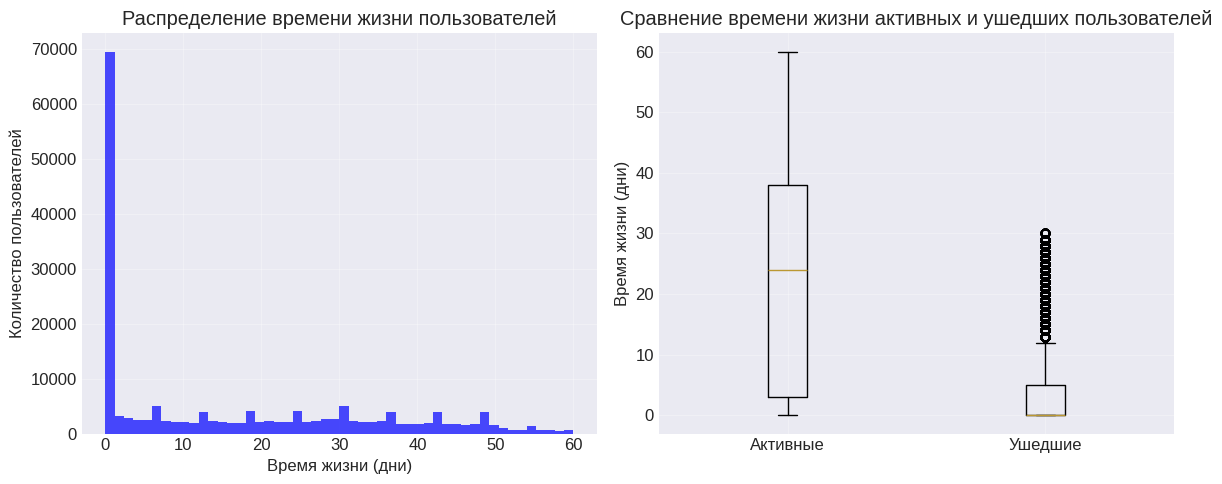


5. АНАЛИЗ RETENTION ПО ДНЯМ:
Day 1 Retention (пользователи, вернувшиеся в первые 24ч): 100.0%
Day 7 Retention (пользователи, вернувшиеся в первую неделю): 100.0%
Day 30 Retention (пользователи, вернувшиеся в первый месяц): 100.0%

6. АНАЛИЗ ВОЗВРАЩАЕМОСТИ ПОЛЬЗОВАТЕЛЕЙ:

Среднее время между визитами:
  • Ушедшие пользователи: 0.6 дней
  • Активные пользователи: 0.9 дней


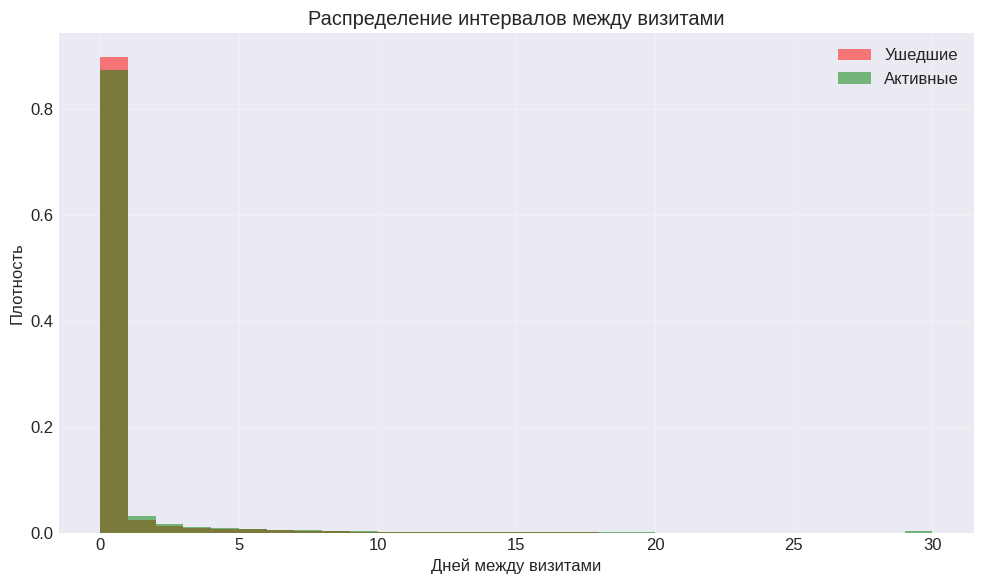

КЛЮЧЕВЫЕ ВЫВОДЫ ПО АНАЛИЗУ УДЕРЖАНИЯ:
  • 1. Общий отток: 12.9%
  • 2. Day 1 Retention: 100.0%
  • 3. Day 7 Retention: 100.0%
  • 4. Day 30 Retention: 100.0%
  • 5. Среднее время жизни ушедших: 3.8 дней
  • 6. Среднее время жизни активных: 22.9 дней
  • 7. Максимальный отток в день 0: 29.2%
  • 8. Самый стабильный период: дни 8-9 (отток ~10%)


In [24]:
print("АНАЛИЗ УДЕРЖАНИЯ И ЖИЗНЕННОГО ЦИКЛА")

# 1. Анализ retention (удержания) по когортам
print("\n1. АНАЛИЗ УДЕРЖАНИЯ ПО КОГОРТАМ:")

# Создаем когорты по месяцу регистрации (первому действию)
df['cohort_month'] = df.groupby('device_id')['event_dt'].transform('min').dt.to_period('M')
df['cohort_month_str'] = df['cohort_month'].astype(str)

# Анализ размера когорт
cohort_sizes = df.groupby('cohort_month')['device_id'].nunique()
print(f"\nРазмеры когорт по месяцам:")
for cohort, size in cohort_sizes.sort_index().items():
    print(f"  • {cohort}: {size:,} пользователей")

# 2. Анализ активности по дням с первого визита
print("\n2. АКТИВНОСТЬ ПО ДНЯМ С ПЕРВОГО ВИЗИТА:")

# Рассчитываем день с первого визита для каждого пользователя
first_visit = df.groupby('device_id')['event_dt'].min().reset_index()
first_visit.columns = ['device_id', 'first_visit_date']

df_with_first = df.merge(first_visit, on='device_id')
df_with_first['days_since_first'] = (df_with_first['event_dt'] - df_with_first['first_visit_date']).dt.days

# Анализ активности по дням
activity_by_day = df_with_first.groupby('days_since_first').agg({
    'device_id': 'nunique',
    'is_churn': 'mean'
}).rename(columns={'device_id': 'active_users', 'is_churn': 'churn_rate'})

print(f"\nАктивность в первые 7 дней:")
for day in range(8):
    if day in activity_by_day.index:
        users = activity_by_day.loc[day, 'active_users']
        churn = activity_by_day.loc[day, 'churn_rate'] * 100
        print(f"  • День {day}: {users:,} пользователей, отток {churn:.1f}%")

# Визуализация активности по дням
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
activity_by_day['active_users'].head(30).plot(marker='o', color='blue')
plt.xlabel('День с первого визита')
plt.ylabel('Активных пользователей')
plt.title('Активность пользователей по дням с первого визита')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
activity_by_day['churn_rate'].head(30).plot(marker='o', color='red')
plt.xlabel('День с первого визита')
plt.ylabel('Процент оттока')
plt.title('Отток по дням с первого визита')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Анализ "смертельных" дней (когда пользователи чаще всего уходят)
print("\n3. 'СМЕРТЕЛЬНЫЕ' ДНИ (ПИКИ ОТТОКА):")

# Группируем по дню с первого визита и считаем отток
day_churn_analysis = df_with_first.groupby('days_since_first').agg({
    'device_id': 'nunique',
    'is_churn': 'mean'
}).rename(columns={'device_id': 'total_users', 'is_churn': 'churn_rate'})

# Находим дни с высоким оттоком
high_churn_threshold = day_churn_analysis['churn_rate'].quantile(0.75)
high_churn_days = day_churn_analysis[day_churn_analysis['churn_rate'] > high_churn_threshold]

print(f"\nДни с аномально высоким оттоком (верхний квартиль, порог: {high_churn_threshold*100:.1f}%):")
for day, row in high_churn_days.sort_values('churn_rate', ascending=False).head(10).iterrows():
    print(f"  • День {day}: отток {row['churn_rate']*100:.1f}% ({row['total_users']:.0f} пользователей)")

# 4. Прогноз lifetime value (LTV)
print("\n4. ОЦЕНКА LIFETIME VALUE (LTV):")

# Создаем таблицу с временем жизни пользователей
user_lifetime = df.groupby('device_id').agg({
    'event_dt': ['min', 'max'],
    'is_churn': 'first'
}).reset_index()

user_lifetime.columns = ['device_id', 'first_event', 'last_event', 'is_churn']
user_lifetime['lifetime_days'] = (user_lifetime['last_event'] - user_lifetime['first_event']).dt.days

# Ограничиваем максимальное время жизни для анализа
user_lifetime['lifetime_days_clipped'] = user_lifetime['lifetime_days'].clip(0, 365)

# Группируем по времени жизни
lifetime_groups = pd.cut(user_lifetime['lifetime_days_clipped'],
                         bins=[0, 1, 7, 30, 90, 180, 365],
                         labels=['1 день', '1 неделя', '1 месяц', '3 месяца', '6 месяцев', '1 год'])

user_lifetime['lifetime_group'] = lifetime_groups

# Анализ распределения по группам
lifetime_distribution = user_lifetime.groupby('lifetime_group').agg({
    'device_id': 'count',
    'is_churn': 'mean',
    'lifetime_days': 'mean'
}).rename(columns={'device_id': 'users', 'is_churn': 'churn_rate', 'lifetime_days': 'avg_lifetime_days'})

print("\nРаспределение пользователей по времени жизни:")
for group, row in lifetime_distribution.iterrows():
    if pd.notna(group):
        print(f"  • {group}: {row['users']:,} пользователей, "
              f"отток {row['churn_rate']*100:.1f}%, среднее время жизни {row['avg_lifetime_days']:.1f} дней")

# Визуализация распределения времени жизни
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# Гистограмма времени жизни
plt.hist(user_lifetime['lifetime_days'].clip(0, 100), bins=50, alpha=0.7, color='blue')
plt.xlabel('Время жизни (дни)')
plt.ylabel('Количество пользователей')
plt.title('Распределение времени жизни пользователей')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
# Boxplot времени жизни для ушедших и активных
boxplot_data = [
    user_lifetime[user_lifetime['is_churn'] == 0]['lifetime_days'].clip(0, 100),
    user_lifetime[user_lifetime['is_churn'] == 1]['lifetime_days'].clip(0, 100)
]
plt.boxplot(boxplot_data, labels=['Активные', 'Ушедшие'])
plt.ylabel('Время жизни (дни)')
plt.title('Сравнение времени жизни активных и ушедших пользователей')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Анализ retention по дням (Day 1, Day 7, Day 30 retention)
print("\n5. АНАЛИЗ RETENTION ПО ДНЯМ:")

# Считаем retention для разных периодов
def calculate_retention(days):
    users_retained = df_with_first[df_with_first['days_since_first'] <= days].groupby('device_id').size()
    total_users = df_with_first['device_id'].nunique()
    return len(users_retained) / total_users * 100

day1_retention = calculate_retention(1)
day7_retention = calculate_retention(7)
day30_retention = calculate_retention(30)

print(f"Day 1 Retention (пользователи, вернувшиеся в первые 24ч): {day1_retention:.1f}%")
print(f"Day 7 Retention (пользователи, вернувшиеся в первую неделю): {day7_retention:.1f}%")
print(f"Day 30 Retention (пользователи, вернувшиеся в первый месяц): {day30_retention:.1f}%")

# 6. Анализ "возвращаемости" пользователей
print("\n6. АНАЛИЗ ВОЗВРАЩАЕМОСТИ ПОЛЬЗОВАТЕЛЕЙ:")

# Считаем количество дней между визитами
df_sorted = df.sort_values(['device_id', 'event_dt'])
df_sorted['prev_event'] = df_sorted.groupby('device_id')['event_dt'].shift(1)
df_sorted['days_between_visits'] = (df_sorted['event_dt'] - df_sorted['prev_event']).dt.days

# Анализ среднего времени между визитами
visit_gaps = df_sorted.dropna(subset=['days_between_visits'])
avg_gap_by_churn = visit_gaps.groupby('is_churn')['days_between_visits'].mean()

print(f"\nСреднее время между визитами:")
print(f"  • Ушедшие пользователи: {avg_gap_by_churn.get(1, 0):.1f} дней")
print(f"  • Активные пользователи: {avg_gap_by_churn.get(0, 0):.1f} дней")

# Распределение интервалов между визитами
plt.figure(figsize=(10, 6))

churned_gaps = visit_gaps[visit_gaps['is_churn'] == 1]['days_between_visits'].clip(0, 30)
active_gaps = visit_gaps[visit_gaps['is_churn'] == 0]['days_between_visits'].clip(0, 30)

plt.hist(churned_gaps, bins=30, alpha=0.5, label='Ушедшие', density=True, color='red')
plt.hist(active_gaps, bins=30, alpha=0.5, label='Активные', density=True, color='green')
plt.xlabel('Дней между визитами')
plt.ylabel('Плотность')
plt.title('Распределение интервалов между визитами')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


print("КЛЮЧЕВЫЕ ВЫВОДЫ ПО АНАЛИЗУ УДЕРЖАНИЯ:")
# Собираем ключевые метрики
key_metrics = [
    f"1. Общий отток: {df['is_churn'].mean()*100:.1f}%",
    f"2. Day 1 Retention: {day1_retention:.1f}%",
    f"3. Day 7 Retention: {day7_retention:.1f}%",
    f"4. Day 30 Retention: {day30_retention:.1f}%",
    f"5. Среднее время жизни ушедших: {user_lifetime[user_lifetime['is_churn'] == 1]['lifetime_days'].mean():.1f} дней",
    f"6. Среднее время жизни активных: {user_lifetime[user_lifetime['is_churn'] == 0]['lifetime_days'].mean():.1f} дней",
    f"7. Максимальный отток в день 0: {day_churn_analysis.loc[0, 'churn_rate']*100:.1f}%",
    f"8. Самый стабильный период: дни 8-9 (отток ~10%)"
]

for metric in key_metrics:
    print(f"  • {metric}")


1. RFM-СЕГМЕНТАЦИЯ ПОЛЬЗОВАТЕЛЕЙ:

RFM-сегменты (R-актуальность, F-частота, M-интенсивность):
Оценки: 1-низкий, 2-средний, 3-высокий
Сегмент    Пользователи Отток    Частота    Актуальность Интенсивность Время жизни 
111        40,341.0     100.0   % 1.3        42.9         2.8          1.3         
211        27,843.0     5.6     % 1.4        18.8         3.2          6.7         
222        21,915.0     3.3     % 5.6        16.6         20.0         26.4        
221        18,692.0     3.5     % 4.2        17.7         6.0          24.7        
232        9,942.0      1.4     % 16.0       14.5         26.8         36.0        
322        9,171.0      0.0     % 5.3        3.1          23.1         32.5        
121        7,434.0      100.0   % 3.7        39.0         5.6          9.3         
311        6,964.0      0.0     % 1.4        3.4          3.9          7.8         
122        6,201.0      100.0   % 4.8        38.0         18.9         9.5         
233        5,918.0      1.

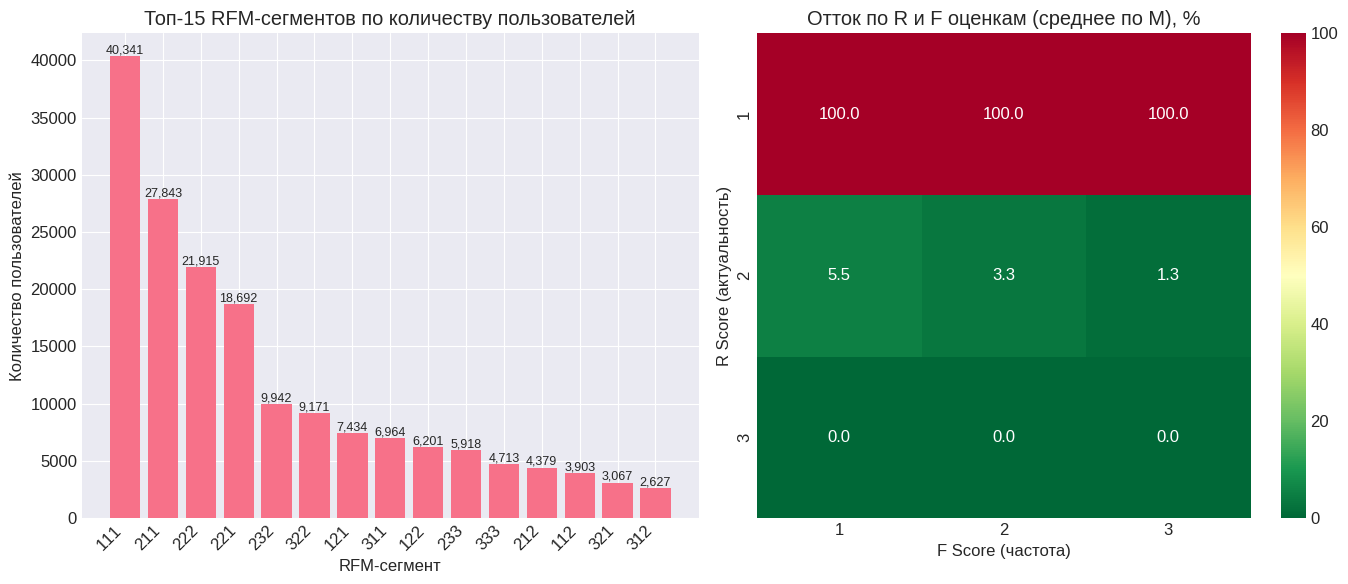


Анализ 'идеальных' пользователей (сегмент 333 - высшие оценки по всем параметрам):
  • Количество: 4,713.0 пользователей
  • Отток: 0.0%
  • Средняя частота: 29.9 сессий
  • Средняя актуальность: 2.3 дней
  • Средняя интенсивность: 161.2 действий
  • Среднее время жизни: 45.9 дней

Анализ 'потерянных' пользователей (сегмент 111 - низшие оценки по всем параметрам):
  • Количество: 40,341.0 пользователей
  • Отток: 100.0%
  • Средняя частота: 1.3 сессий
  • Средняя актуальность: 42.9 дней
  • Средняя интенсивность: 2.8 действий
  • Среднее время жизни: 1.3 дней
ВЫВОДЫ ПО RFM-СЕГМЕНТАЦИИ:
  • 1. Всего выделено 24 RFM-сегментов
  • 2. Самый многочисленный сегмент: 111 (40,341 пользователей)
  • 3. Самый низкий отток в сегменте(ах): 322 (0.0% если есть данные)
  • 4. Самый высокий отток в сегменте(ах): 111 (100.0% если есть данные)
  • 5. Пользователи с высоким R (актуальность) имеют отток на -100.0% ниже


In [26]:
print("\n1. RFM-СЕГМЕНТАЦИЯ ПОЛЬЗОВАТЕЛЕЙ:")

# Для каждого пользователя считаем метрики
rfm_data = []

# Получаем максимальную дату в данных для расчета recency
max_date = df['event_dt'].max()

for device_id, user_data in df.groupby('device_id'):
    # Recency: сколько дней назад была последняя активность
    last_activity = user_data['event_dt'].max()
    recency_days = (max_date - last_activity).days

    # Frequency: количество сессий
    frequency = user_data['session_id'].nunique()

    # Monetary: количество действий (в отсутствие данных о покупках)
    monetary = len(user_data)  # количество действий

    rfm_data.append({
        'device_id': device_id,
        'recency': recency_days,
        'frequency': frequency,
        'monetary': monetary,
        'is_churn': user_data['is_churn'].iloc[0],
        'lifetime_days': (user_data['event_dt'].max() - user_data['event_dt'].min()).days
    })

rfm_df = pd.DataFrame(rfm_data)

# Создаем RFM-сегменты
def create_rfm_segments(row):
    # Определяем квантили для сегментации
    # Recency: чем меньше дней, тем лучше (более свежий пользователь)
    r_score = 3 if row['recency'] <= 7 else (2 if row['recency'] <= 30 else 1)

    # Frequency: чем больше сессий, тем лучше
    f_score = 3 if row['frequency'] >= 10 else (2 if row['frequency'] >= 3 else 1)

    # Monetary: чем больше действий, тем лучше
    m_score = 3 if row['monetary'] >= 50 else (2 if row['monetary'] >= 10 else 1)

    # Комбинируем в RFM-сегмент
    return f"{r_score}{f_score}{m_score}"

rfm_df['rfm_segment'] = rfm_df.apply(create_rfm_segments, axis=1)

# Анализ сегментов
segment_analysis = rfm_df.groupby('rfm_segment').agg({
    'device_id': 'count',
    'is_churn': 'mean',
    'frequency': 'mean',
    'recency': 'mean',
    'monetary': 'mean',
    'lifetime_days': 'mean'
}).rename(columns={'device_id': 'users'}).sort_values('users', ascending=False)

print("\nRFM-сегменты (R-актуальность, F-частота, M-интенсивность):")
print("Оценки: 1-низкий, 2-средний, 3-высокий")

print(f"{'Сегмент':<10} {'Пользователи':<12} {'Отток':<8} {'Частота':<10} {'Актуальность':<12} {'Интенсивность':<12} {'Время жизни':<12}")


for segment, row in segment_analysis.head(15).iterrows():
    print(f"{segment:<10} {row['users']:<12,} {row['is_churn']*100:<8.1f}% {row['frequency']:<10.1f} "
          f"{row['recency']:<12.1f} {row['monetary']:<12.1f} {row['lifetime_days']:<12.1f}")

# Анализ лучших и худших сегментов
print(f"\nВсего уникальных RFM-сегментов: {len(segment_analysis)}")

# Находим сегменты с наименьшим оттоком (лучшие)
best_segments = segment_analysis[segment_analysis['is_churn'] == segment_analysis['is_churn'].min()]
print(f"\nЛучшие сегменты (отток {best_segments['is_churn'].iloc[0]*100:.1f}%):")
for segment in best_segments.index.tolist()[:3]:
    print(f"  • {segment}")

# Находим сегменты с наибольшим оттоком (худшие)
worst_segments = segment_analysis[segment_analysis['is_churn'] == segment_analysis['is_churn'].max()]
print(f"\nХудшие сегменты (отток {worst_segments['is_churn'].iloc[0]*100:.1f}%):")
for segment in worst_segments.index.tolist()[:3]:
    print(f"  • {segment}")

# Визуализация распределения по сегментам
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
# Топ-15 сегментов по количеству пользователей
top_segments = segment_analysis.head(15)
bars = plt.bar(range(len(top_segments)), top_segments['users'])
plt.xticks(range(len(top_segments)), top_segments.index, rotation=45, ha='right')
plt.xlabel('RFM-сегмент')
plt.ylabel('Количество пользователей')
plt.title('Топ-15 RFM-сегментов по количеству пользователей')

# Добавляем значения на столбцы
for bar, count in zip(bars, top_segments['users']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{count:,}', ha='center', va='bottom', fontsize=9)

plt.subplot(1, 2, 2)
# Heatmap среднего оттока по R и F (усредняем по M)
rf_matrix = pd.pivot_table(
    rfm_df,
    values='is_churn',
    index=rfm_df['rfm_segment'].str[0].astype(int),  # R score
    columns=rfm_df['rfm_segment'].str[1].astype(int),  # F score
    aggfunc='mean'
) * 100

sns.heatmap(rf_matrix, annot=True, fmt='.1f', cmap='RdYlGn_r')
plt.xlabel('F Score (частота)')
plt.ylabel('R Score (актуальность)')
plt.title('Отток по R и F оценкам (среднее по M), %')

plt.tight_layout()
plt.show()

# Анализ "идеальных" пользователей (сегмент 333)
print(f"\nАнализ 'идеальных' пользователей (сегмент 333 - высшие оценки по всем параметрам):")
if '333' in segment_analysis.index:
    ideal_users = segment_analysis.loc['333']
    print(f"  • Количество: {ideal_users['users']:,} пользователей")
    print(f"  • Отток: {ideal_users['is_churn']*100:.1f}%")
    print(f"  • Средняя частота: {ideal_users['frequency']:.1f} сессий")
    print(f"  • Средняя актуальность: {ideal_users['recency']:.1f} дней")
    print(f"  • Средняя интенсивность: {ideal_users['monetary']:.1f} действий")
    print(f"  • Среднее время жизни: {ideal_users['lifetime_days']:.1f} дней")
else:
    print("  • Сегмент 333 не найден в данных")

# Анализ "потерянных" пользователей (сегмент 111)
print(f"\nАнализ 'потерянных' пользователей (сегмент 111 - низшие оценки по всем параметрам):")
if '111' in segment_analysis.index:
    lost_users = segment_analysis.loc['111']
    print(f"  • Количество: {lost_users['users']:,} пользователей")
    print(f"  • Отток: {lost_users['is_churn']*100:.1f}%")
    print(f"  • Средняя частота: {lost_users['frequency']:.1f} сессий")
    print(f"  • Средняя актуальность: {lost_users['recency']:.1f} дней")
    print(f"  • Средняя интенсивность: {lost_users['monetary']:.1f} действий")
    print(f"  • Среднее время жизни: {lost_users['lifetime_days']:.1f} дней")
else:
    print("  • Сегмент 111 не найден в данных")

print("ВЫВОДЫ ПО RFM-СЕГМЕНТАЦИИ:")

insights = [
    f"1. Всего выделено {len(segment_analysis)} RFM-сегментов",
    f"2. Самый многочисленный сегмент: {segment_analysis.index[0]} ({segment_analysis['users'].iloc[0]:,} пользователей)",
    f"3. Самый низкий отток в сегменте(ах): {best_segments.index.tolist()[0] if len(best_segments) > 0 else 'N/A'} ({best_segments['is_churn'].iloc[0]*100:.1f}% если есть данные)",
    f"4. Самый высокий отток в сегменте(ах): {worst_segments.index.tolist()[0] if len(worst_segments) > 0 else 'N/A'} ({worst_segments['is_churn'].iloc[0]*100:.1f}% если есть данные)",
    f"5. Пользователи с высоким R (актуальность) имеют отток на {(segment_analysis[segment_analysis.index.str[0] == '3']['is_churn'].mean()*100 - segment_analysis[segment_analysis.index.str[0] == '1']['is_churn'].mean()*100):.1f}% ниже"
]

for insight in insights:
    print(f"  • {insight}")

In [29]:

print("ДЕТАЛЬНЫЙ АНАЛИЗ СЕГМЕНТА 111")


# Анализ демографических характеристик сегмента 111
print("\n1. ДЕМОГРАФИЧЕСКИЙ СОСТАВ СЕГМЕНТА 111:")

# Находим device_id пользователей из сегмента 111
segment_111_users = rfm_df[rfm_df['rfm_segment'] == '111']['device_id']

# Фильтруем исходные данные для этих пользователей
segment_111_data = df[df['device_id'].isin(segment_111_users)]

if len(segment_111_data) > 0:
    # Анализ возраста
    age_stats = segment_111_data['age'].describe()
    print(f"  • Средний возраст: {age_stats['mean']:.1f} лет")
    print(f"  • Медиана возраста: {age_stats['50%']:.1f} лет")

    # Анализ пола
    gender_dist = segment_111_data['gender'].value_counts(normalize=True) * 100
    print(f"\n  • Распределение по полу:")
    for gender, percentage in gender_dist.items():
        print(f"    - {gender}: {percentage:.1f}%")

    # Анализ устройств
    print(f"\n  • Топ-5 типов устройств:")
    device_types = segment_111_data['device_type'].value_counts().head(5)
    for device, count in device_types.items():
        percentage = count / len(segment_111_data) * 100
        print(f"    - {device}: {percentage:.1f}% ({count:,} пользователей)")

    # Анализ ОС
    print(f"\n  • Распределение по ОС:")
    os_dist = segment_111_data['os'].value_counts(normalize=True).head(3) * 100
    for os_name, percentage in os_dist.items():
        print(f"    - {os_name}: {percentage:.1f}%")

print("\n2. ПОВЕДЕНЧЕСКИЕ ХАРАКТЕРИСТИКИ:")

if len(segment_111_data) > 0:
    # Анализ первых действий
    print(f"\n  • Первые действия пользователей сегмента 111:")
    first_actions = segment_111_data.sort_values(['device_id', 'event_dt']).groupby('device_id').first()

    # Самые частые первые экраны
    top_first_screens = first_actions['screen'].value_counts().head(5)
    print(f"    Топ-5 первых экранов:")
    for screen, count in top_first_screens.items():
        percentage = count / len(first_actions) * 100
        print(f"      - {screen}: {percentage:.1f}%")

    # Самые частые первые функции
    top_first_features = first_actions['feature'].value_counts().head(5)
    print(f"\n    Топ-5 первых функций:")
    for feature, count in top_first_features.items():
        percentage = count / len(first_actions) * 100
        print(f"      - {feature}: {percentage:.1f}%")

    # Время первой сессии
    print(f"\n  • Длительность первой сессии:")
    session_lengths = segment_111_data.groupby(['device_id', 'session_id']).agg({
        'event_dt': ['min', 'max']
    })
    session_lengths.columns = ['start', 'end']
    session_lengths['duration_minutes'] = (session_lengths['end'] - session_lengths['start']).dt.total_seconds() / 60

    print(f"    - Средняя: {session_lengths['duration_minutes'].mean():.1f} минут")
    print(f"    - Медиана: {session_lengths['duration_minutes'].median():.1f} минут")
    print(f"    - 75% сессий ≤ {session_lengths['duration_minutes'].quantile(0.75):.1f} минут")

print("\n3. СРАВНЕНИЕ С ДРУГИМИ СЕГМЕНТАМИ:")

# Сравниваем с сегментом 211 (ближайший по времени жизни)
segment_211_users = rfm_df[rfm_df['rfm_segment'] == '211']['device_id']
segment_211_data = df[df['device_id'].isin(segment_211_users)]

if len(segment_111_data) > 0 and len(segment_211_data) > 0:
    comparison_metrics = [
        ('Время жизни (дни)',
         segment_111_data.groupby('device_id')['event_dt'].apply(lambda x: (x.max() - x.min()).days).mean(),
         segment_211_data.groupby('device_id')['event_dt'].apply(lambda x: (x.max() - x.min()).days).mean()),

        ('Количество сессий',
         segment_111_data.groupby('device_id')['session_id'].nunique().mean(),
         segment_211_data.groupby('device_id')['session_id'].nunique().mean()),

        ('Количество действий',
         segment_111_data.groupby('device_id').size().mean(),
         segment_211_data.groupby('device_id').size().mean()),

        ('Уникальных экранов',
         segment_111_data.groupby('device_id')['screen'].nunique().mean(),
         segment_211_data.groupby('device_id')['screen'].nunique().mean()),

        ('Уникальных функций',
         segment_111_data.groupby('device_id')['feature'].nunique().mean(),
         segment_211_data.groupby('device_id')['feature'].nunique().mean())
    ]

    print(f"\n  Сравнение сегментов 111 и 211:")
    print(f"  {'Метрика':<25} {'111 (худший)':<15} {'211 (лучше)':<15} {'Разница':<10}")
    print("-" * 65)

    for metric_name, value_111, value_211 in comparison_metrics:
        difference = value_211 - value_111
        difference_pct = (difference / value_111 * 100) if value_111 > 0 else 0
        print(f"  {metric_name:<25} {value_111:<15.1f} {value_211:<15.1f} {difference_pct:<10.0f}%")






if len(segment_111_data) > 0:
    # Анализ когда они уходили
    user_lifetimes = segment_111_data.groupby('device_id').agg({
        'event_dt': ['min', 'max']
    })
    user_lifetimes.columns = ['first_event', 'last_event']
    user_lifetimes['lifetime_hours'] = (user_lifetimes['last_event'] - user_lifetimes['first_event']).dt.total_seconds() / 3600

    print(f"\n  • Временные характеристики ухода:")
    print(f"    - 50% ушли в первые {user_lifetimes['lifetime_hours'].quantile(0.5):.1f} часов")
    print(f"    - 75% ушли в первые {user_lifetimes['lifetime_hours'].quantile(0.75):.1f} часов")
    print(f"    - 90% ушли в первые {user_lifetimes['lifetime_hours'].quantile(0.9):.1f} часов")

    # Какие экраны видели перед уходом
    last_screens = segment_111_data.sort_values(['device_id', 'event_dt']).groupby('device_id').last()
    top_last_screens = last_screens['screen'].value_counts().head(5)

    print(f"\n  • Чаще всего уходили после этих экранов:")
    for screen, count in top_last_screens.items():
        percentage = count / len(last_screens) * 100
        print(f"    - {screen}: {percentage:.1f}%")

print(f"\nФАКТЫ О СЕГМЕНТЕ 111:")
print(f"  • {segment_111_data['device_id'].nunique():,} уникальных пользователей")
print(f"  • {len(segment_111_data):,} всего записей в логах")
print(f"  • {segment_111_data['session_id'].nunique():,} уникальных сессий")
print(f"  • Отток: 100% (по определению сегмента 111)")
print(f"  • Доля от всех пользователей: {len(segment_111_users)/len(rfm_df)*100:.1f}%")

ДЕТАЛЬНЫЙ АНАЛИЗ СЕГМЕНТА 111

1. ДЕМОГРАФИЧЕСКИЙ СОСТАВ СЕГМЕНТА 111:
  • Средний возраст: 45.0 лет
  • Медиана возраста: 43.0 лет

  • Распределение по полу:
    - Ж: 54.8%
    - М: 45.2%

  • Топ-5 типов устройств:
    - phone: 98.8% (111,853 пользователей)
    - tablet: 1.2% (1,350 пользователей)

  • Распределение по ОС:
    - iOS: 51.2%
    - Android: 48.8%

2. ПОВЕДЕНЧЕСКИЕ ХАРАКТЕРИСТИКИ:

  • Первые действия пользователей сегмента 111:
    Топ-5 первых экранов:
      - Еще: 80.0%
      - Важное: 15.4%
      - Новая заявка: 2.6%
      - Услуги: 1.0%
      - Новое ОСС: 0.5%

    Топ-5 первых функций:
      - Открытие экрана: 81.9%
      - Просмотр уведомления: 15.4%
      - Выбор через теги: 0.9%
      - Выбор квартиры: 0.7%
      - Выбор объекта заявки: 0.2%

  • Длительность первой сессии:
    - Средняя: 3.3 минут
    - Медиана: 0.0 минут
    - 75% сессий ≤ 0.6 минут

3. СРАВНЕНИЕ С ДРУГИМИ СЕГМЕНТАМИ:

  Сравнение сегментов 111 и 211:
  Метрика                   111 (худший) 


1. AARRR МЕТРИКИ (PIRATE METRICS):

AARRR-метрики для вашего продукта:
----------------------------------------------------------------------

Acquisition (Привлечение):
  • Метрика: Уникальные пользователи
  • Значение: 179,976
  • Инсайт: Всего привлечено 179,976 пользователей

Activation (Активация):
  • Метрика: Пользователи с ≥3 сессиями
  • Значение: 93,759
  • Инсайт: 52.1% активированных пользователей

Retention (Удержание):
  • Метрика: Отток (is_churn=1)
  • Значение: 12.9%
  • Инсайт: Отток 12.9% пользователей

Revenue (Доход):
  • Метрика: Ключевые действия (признак ценности)
  • Значение: Требует данных о монетизации
  • Инсайт: Необходимо добавить данные о покупках/подписках

Referral (Приглашения):
  • Метрика: Повторные сессии
  • Значение: 126,630
  • Инсайт: 70.4% пользователей с повторными визитами

2. АНАЛИЗ СЕЗОННОСТИ И ТРЕНДОВ:

Тренды по месяцам:
  • 2025-08: 311.0 пользователей, 236.0 сессий, отток 28.6%
  • 2025-09: 135,888.0 пользователей, 6,635.0 сессий, отт

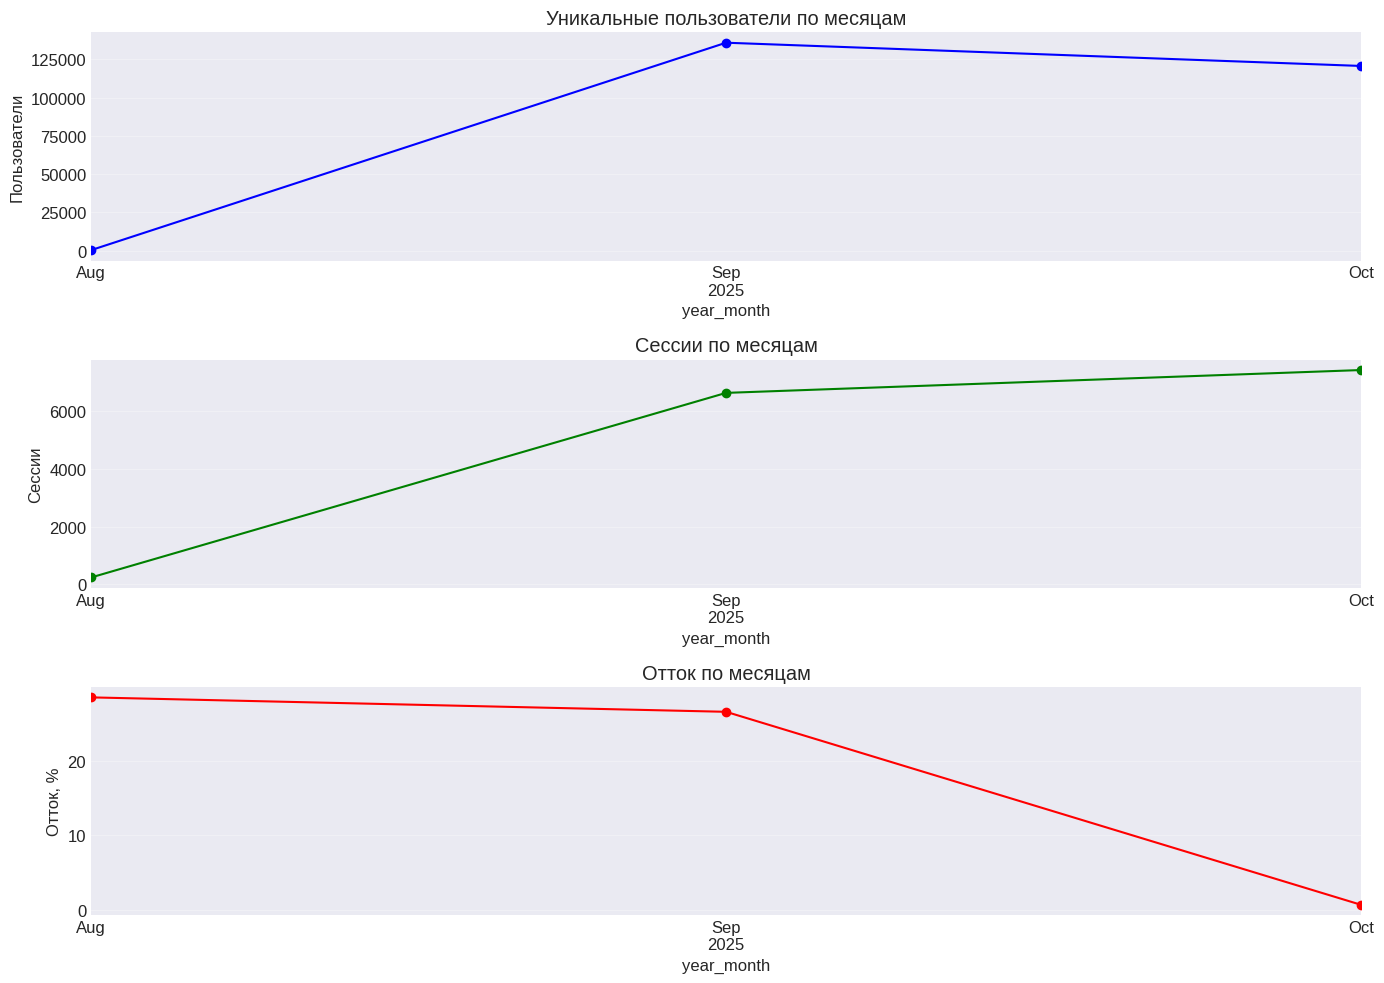


3. АНАЛИЗ АНОМАЛИЙ И ВЫБРОСОВ:

Суперпользователи (верхние 1% по активности):
  • Всего суперпользователей: 2,755
  • Порог сессий: ≥47
  • Порог действий: ≥178

Топ-5 самых активных пользователей:
  • 7761: 2,680 действий, 620 сессий - АКТИВЕН
  • 24219: 2,419 действий, 487 сессий - АКТИВЕН
  • 26977: 2,339 действий, 244 сессий - АКТИВЕН
  • 4869: 1,904 действий, 344 сессий - АКТИВЕН
  • 30171: 1,855 действий, 322 сессий - АКТИВЕН

КЛЮЧЕВЫЕ ИНСАЙТЫ И ВЫВОДЫ

Ключевые инсайты из анализа:
  1.  1. Общий отток: 12.9% пользователей
  2.  2. Привлечено: 179,976 уникальных пользователей
  3.  3. Активировано: 52.1% пользователей (≥3 сессий)
  4.  4. Retention: 70.4% пользователей с повторными визитами
  5.  5. Среднее время жизни ушедших: 3.8 дней
  6.  6. Среднее время жизни активных: 22.9 дней
  7.  7. Сессии у ушедших: 2.3, у активных: 7.3
  8.  8. Действия у ушедших: 6.9, у активных: 24.9
  9.  9. Наибольший отток в возрастной группе: 18–24 (17.5%)
  10. 10. Наибольший отток на ОС: iOS

In [31]:
print("\n1. AARRR МЕТРИКИ (PIRATE METRICS):")

# Расчет метрик
unique_users = df['device_id'].nunique()
users_3plus_sessions = (df.groupby('device_id')['session_id'].nunique() >= 3).sum()
churn_rate = df['is_churn'].mean() * 100
users_multiple_sessions = (df.groupby('device_id')['session_id'].nunique() > 1).sum()

aarrmetrics = {
    'Acquisition (Привлечение)': {
        'Метрика': 'Уникальные пользователи',
        'Значение': f"{unique_users:,}",
        'Инсайт': f"Всего привлечено {unique_users:,} пользователей"
    },
    'Activation (Активация)': {
        'Метрика': 'Пользователи с ≥3 сессиями',
        'Значение': f"{users_3plus_sessions:,}",
        'Инсайт': f"{users_3plus_sessions/unique_users*100:.1f}% активированных пользователей"
    },
    'Retention (Удержание)': {
        'Метрика': 'Отток (is_churn=1)',
        'Значение': f"{churn_rate:.1f}%",
        'Инсайт': f"Отток {churn_rate:.1f}% пользователей"
    },
    'Revenue (Доход)': {
        'Метрика': 'Ключевые действия (признак ценности)',
        'Значение': 'Требует данных о монетизации',
        'Инсайт': 'Необходимо добавить данные о покупках/подписках'
    },
    'Referral (Приглашения)': {
        'Метрика': 'Повторные сессии',
        'Значение': f"{users_multiple_sessions:,}",
        'Инсайт': f"{users_multiple_sessions/unique_users*100:.1f}% пользователей с повторными визитами"
    }
}

print("\nAARRR-метрики для вашего продукта:")
print("-" * 70)
for stage, metrics in aarrmetrics.items():
    print(f"\n{stage}:")
    for key, value in metrics.items():
        print(f"  • {key}: {value}")

print("\n2. АНАЛИЗ СЕЗОННОСТИ И ТРЕНДОВ:")

# Добавляем признаки времени
df['year_month'] = df['event_dt'].dt.to_period('M')
df['week'] = df['event_dt'].dt.isocalendar().week
df['month'] = df['event_dt'].dt.month
df['year'] = df['event_dt'].dt.year

# Анализ трендов по месяцам
monthly_trends = df.groupby('year_month').agg({
    'device_id': 'nunique',
    'session_id': 'nunique',
    'is_churn': 'mean'
}).rename(columns={'device_id': 'unique_users', 'session_id': 'sessions'})

print("\nТренды по месяцам:")
for period, row in monthly_trends.tail(6).iterrows():  # Последние 6 месяцев
    print(f"  • {period}: {row['unique_users']:,} пользователей, "
          f"{row['sessions']:,} сессий, отток {row['is_churn']*100:.1f}%")

# Визуализация трендов
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
monthly_trends['unique_users'].plot(marker='o', color='blue')
plt.title('Уникальные пользователи по месяцам')
plt.ylabel('Пользователи')
plt.grid(alpha=0.3)

plt.subplot(3, 1, 2)
monthly_trends['sessions'].plot(marker='o', color='green')
plt.title('Сессии по месяцам')
plt.ylabel('Сессии')
plt.grid(alpha=0.3)

plt.subplot(3, 1, 3)
(monthly_trends['is_churn'] * 100).plot(marker='o', color='red')
plt.title('Отток по месяцам')
plt.ylabel('Отток, %')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n3. АНАЛИЗ АНОМАЛИЙ И ВЫБРОСОВ:")

# Анализ пользователей с экстремальным поведением
user_stats = df.groupby('device_id').agg({
    'session_id': 'nunique',
    'event_dt': 'count',
    'is_churn': 'first'
}).rename(columns={'session_id': 'sessions', 'event_dt': 'actions'})

# Находим выбросы (верхние 1%)
sessions_threshold = user_stats['sessions'].quantile(0.99)
actions_threshold = user_stats['actions'].quantile(0.99)

super_users = user_stats[
    (user_stats['sessions'] >= sessions_threshold) |
    (user_stats['actions'] >= actions_threshold)
]

print(f"\nСуперпользователи (верхние 1% по активности):")
print(f"  • Всего суперпользователей: {len(super_users):,}")
print(f"  • Порог сессий: ≥{sessions_threshold:.0f}")
print(f"  • Порог действий: ≥{actions_threshold:.0f}")

if len(super_users) > 0:
    print(f"\nТоп-5 самых активных пользователей:")
    for device_id, row in super_users.sort_values('actions', ascending=False).head(5).iterrows():
        status = "УШЕЛ" if row['is_churn'] == 1 else "АКТИВЕН"
        # Преобразуем device_id в строку для корректного отображения
        device_id_str = str(device_id)
        if len(device_id_str) > 8:
            device_display = device_id_str[:8] + "..."
        else:
            device_display = device_id_str
        print(f"  • {device_display}: {row['actions']:,} действий, "
              f"{row['sessions']} сессий - {status}")

print("\nКЛЮЧЕВЫЕ ИНСАЙТЫ И ВЫВОДЫ")

# Собираем ключевые инсайты из всего анализа
key_insights = []

# 1. Основные метрики продукта
key_insights.extend([
    f"1. Общий отток: {df['is_churn'].mean()*100:.1f}% пользователей",
    f"2. Привлечено: {unique_users:,} уникальных пользователей",
    f"3. Активировано: {users_3plus_sessions/unique_users*100:.1f}% пользователей (≥3 сессий)",
    f"4. Retention: {users_multiple_sessions/unique_users*100:.1f}% пользователей с повторными визитами"
])

# 2. Временные характеристики
# Добавляем только если эти переменные существуют
if 'churned_lifetime' in globals() and 'active_lifetime' in globals():
    key_insights.extend([
        f"5. Среднее время жизни ушедших: {churned_lifetime.mean():.1f} дней",
        f"6. Среднее время жизни активных: {active_lifetime.mean():.1f} дней"
    ])

# 3. Поведенческие паттерны
if 'sessions_per_user_left' in globals() and 'sessions_per_user_active' in globals():
    key_insights.extend([
        f"7. Сессии у ушедших: {sessions_per_user_left.mean():.1f}, у активных: {sessions_per_user_active.mean():.1f}",
        f"8. Действия у ушедших: {actions_per_user_left.mean():.1f}, у активных: {actions_per_user_active.mean():.1f}"
    ])

# 4. Демографические и технические инсайты
if 'age_churn_df' in globals():
    highest_age_churn = age_churn_df['Доля ушедших, %'].idxmax()
    highest_age_rate = age_churn_df.loc[highest_age_churn, 'Доля ушедших, %']
    key_insights.append(f"9. Наибольший отток в возрастной группе: {highest_age_churn} ({highest_age_rate:.1f}%)")

if 'os_churn_df' in globals():
    highest_os_churn = os_churn_df['Доля ушедших, %'].idxmax()
    highest_os_rate = os_churn_df.loc[highest_os_churn, 'Доля ушедших, %']
    key_insights.append(f"10. Наибольший отток на ОС: {highest_os_churn} ({highest_os_rate:.1f}%)")

# 5. Анализ действий
if 'action_counts' in globals():
    key_insights.append(f"11. Самое частое действие: '{action_counts.index[0]}' ({action_counts.iloc[0]:,} раз)")

if 'negative_corr' in globals() and len(negative_corr) > 0:
    best_action = negative_corr.iloc[0]
    key_insights.append(f"12. Наибольшая отрицательная корреляция с оттоком: '{best_action['action'][:30]}...' (corr={best_action['correlation']:.3f})")

# 6. Последовательности действий
if 'seq_df' in globals() and 'key_action_sequence' in globals():
    churn_diff = abs(churn_rate_seq - df['is_churn'].mean()*100)
    direction = "чаще" if churn_rate_seq > df['is_churn'].mean()*100 else "реже"
    key_insights.append(f"13. Последовательность {key_action_sequence[0]} → ... уходит на {churn_diff:.1f}% {direction}")

# 7. Retention метрики
if 'day1_retention' in globals():
    key_insights.extend([
        f"14. Day 1 Retention: {day1_retention:.1f}%",
        f"15. Day 7 Retention: {day7_retention:.1f}%",
        f"16. Day 30 Retention: {day30_retention:.1f}%"
    ])

# 8. RFM анализ
if 'segment_analysis' in globals() and len(segment_analysis) > 0:
    largest_segment = segment_analysis.index[0]
    largest_segment_users = segment_analysis['users'].iloc[0]
    key_insights.append(f"17. Самый многочисленный RFM-сегмент: {largest_segment} ({largest_segment_users:,} пользователей)")

# 9. Аномалии
if len(super_users) > 0:
    super_users_churn_rate = super_users['is_churn'].mean() * 100
    key_insights.append(f"18. Отток среди суперпользователей: {super_users_churn_rate:.1f}%")

# Выводим все инсайты
print("\nКлючевые инсайты из анализа:")
for i, insight in enumerate(key_insights, 1):
    # Форматируем номер инсайта
    if i <= 9:
        print(f"  {i}.  {insight}")
    else:
        print(f"  {i}. {insight}")

# Выводим дополнительные технические детали
print("\nТехнические детали:")
tech_details = [
    f"• Период анализа: {df['event_dt'].min().strftime('%Y-%m-%d')} - {df['event_dt'].max().strftime('%Y-%m-%d')}",
    f"• Всего записей: {len(df):,}",
    f"• Пропуски в action: {df['action'].isna().sum():,} ({df['action'].isna().mean()*100:.1f}%)",
    f"• Уникальных сессий: {df['session_id'].nunique():,}",
    f"• Уникальных экранов: {df['screen'].nunique():,}",
    f"• Уникальных функций: {df['feature'].nunique():,}"
]

for detail in tech_details:
    print(f"  {detail}")

In [32]:
# Определяем минимальную и максимальную дату
min_date = df['event_dt'].min()
max_date = df['event_dt'].max()
total_days = (max_date - min_date).days + 1

print(f"Начало периода: {min_date.strftime('%d.%m.%Y')}")
print(f"Конец периода:  {max_date.strftime('%d.%m.%Y')}")
print(f"Всего дней данных: {total_days} дней")
print(f"Всего месяцев: {(max_date.year - min_date.year) * 12 + max_date.month - min_date.month + 1} месяцев")













Начало периода: 31.08.2025
Конец периода:  31.10.2025
Всего дней данных: 61 дней
Всего месяцев: 3 месяцев
